In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

import gc # Free up memory

import scipy.stats
import scipy.special
import scipy.optimize

import copy

In [13]:
def get_predictions(df, t, start):
    # Previously returned as np array, changed to series for compatability with filtered datasets
    try:
        return df.loc[df.start==start, :].loc[t, 'value']
    except:
        return df.loc[(df.start==start)&np.in1d(df.index, t), 'value']

def ranking(df, ax=None, kwargs={}):

    t = df.index.unique()
    df["Rank"] = np.nan
    for start in df.start.unique():
        pred = get_predictions(df, t, start)

        ranks = scipy.stats.rankdata(pred)

        #ranks = scipy.stats.rankdata(pred)
        
        df.loc[df.start==start, 'Rank'] = ranks

    if ax is not None:
        rank_df = copy.deepcopy(df)
        rank_df = rank_df.assign(value=rank_df.Rank)
        plot_residuals(rank_df, ax, **kwargs)

def MAEs(df):
    df["Observed"] = df.index
    df["Observed"] = df["period"].map(df.set_index("period").loc[df.start==df.start.max(), 'value'])

    ranking(df)
    df["Observed Rank"] = df["period"].map(df.loc[df.start==df.start.max(), 'Rank'])
    
    # was absolute before, value clipped
    df = df.assign(error=(df.value-df.Observed), rank_error = (df.Rank-df["Observed Rank"]))
    df['Absolute Error'] = abs(df.error)
    df['Absolute Rank Error'] = abs(df.rank_error)


    return df

def initialise(df):
    df = df.assign(offset=df.index-df.start, period=df.index)
    df = MAEs(df).reset_index()
    
    df['Std'] = (df.value - df.lower)/1.96
    df.loc[(df.lower==0)&(df.upper==0),'Std'] = 0

    df["Observation Z-score"] = (df['Observed'] - df['value'])/df['Std']
    _ = compare_start(df, "value")
    return df

def compare_start(df, col='Observed', colname="Start Observed", higher_col = "Higher", filter_=None):
    df[colname] = df.start
    df[colname] = df[colname].map(df[df.offset==-1].set_index('start')[col])

    if filter_ is None:
        filter_ = df.index
    df[higher_col] = df[col] > df[colname]

    return df

def plot_expected(df, upper, x='Observed Higher', y='Higher', hue='Start Observed Rank', ax=None):
    if ax is None:
        ax = plt.gca()
    filter_ = (df.offset >= 0) & (df.offset < upper) 
    sns.scatterplot(data = df[filter_].groupby('start').mean(), x=x, y=y, hue=hue, ax=ax)
    sns.regplot(data = df[filter_].groupby('start').mean(), x=x, y=y, scatter=False, ax=ax)

    ax.plot([0, 1], [0, 1])

In [624]:
arma_price = "ARMA Price"
sarimax_price = "SARIMAX Price"

df = pd.read_csv(f"{sarimax_price}.csv", index_col=0)
df = initialise(df)

In [625]:

sarimax_volume = "SARIMAX Volume"

vol_df = pd.read_csv(f"{sarimax_volume}.csv", index_col=0)
vol_df = initialise(vol_df)

In [288]:
prediction_set = (df.offset >=0)
prediction_df = df[prediction_set].dropna()

<AxesSubplot: xlabel='offset', ylabel='rank_error'>

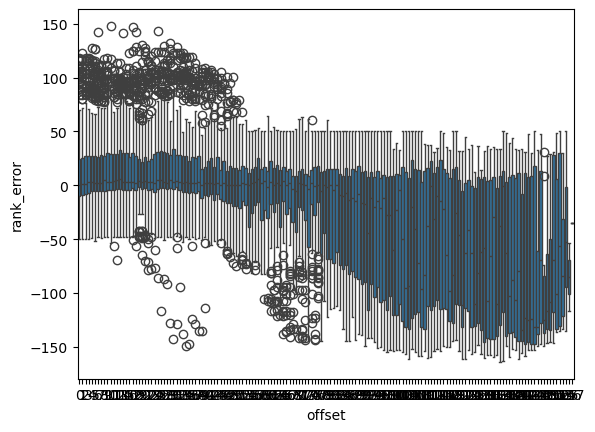

In [289]:
sns.boxplot(df[prediction_set], x='offset', y='rank_error')

SignificanceResult(statistic=0.6268587325817668, pvalue=0.0)


<AxesSubplot: >

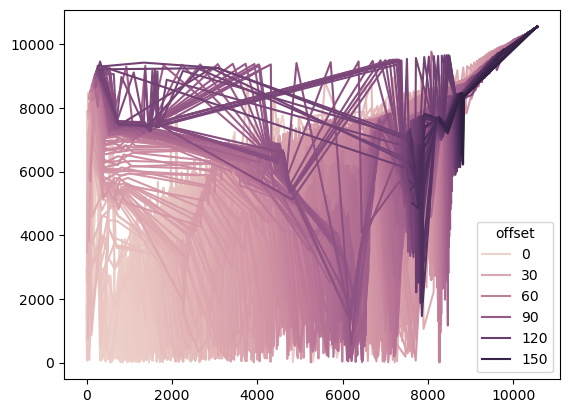

In [290]:
cols = ['Std', 'Absolute Error']
print(scipy.stats.spearmanr(prediction_df[cols[0]], prediction_df[cols[1]]))
sns.lineplot(prediction_df, x=scipy.stats.rankdata(prediction_df[cols[0]]), y=scipy.stats.rankdata(prediction_df[cols[1]]), hue='offset')

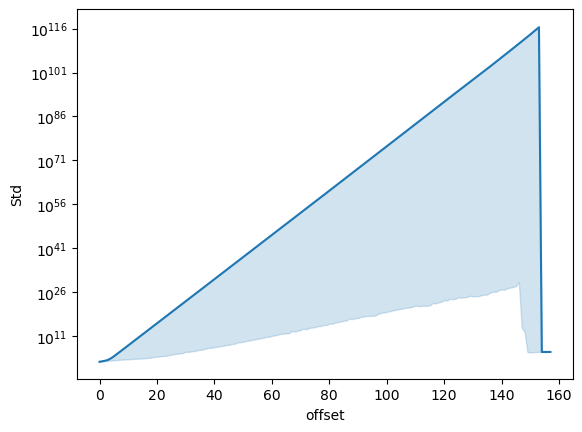

In [291]:
sns.lineplot(prediction_df, x='offset', y='Std')
#plt.ylim(0, 10000)
plt.yscale('log')

<AxesSubplot: xlabel='Observation Z-score', ylabel='Density'>

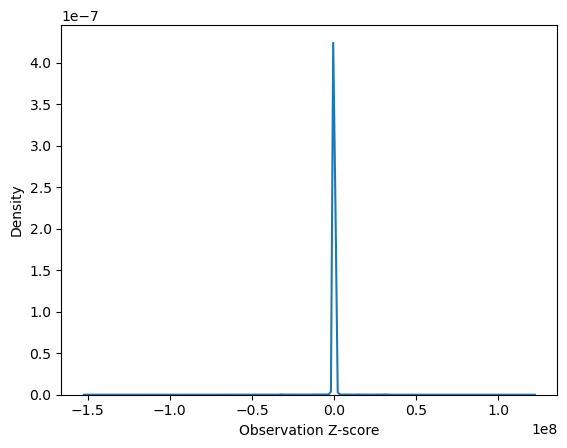

In [292]:
sns.kdeplot(prediction_df, x='Observation Z-score')

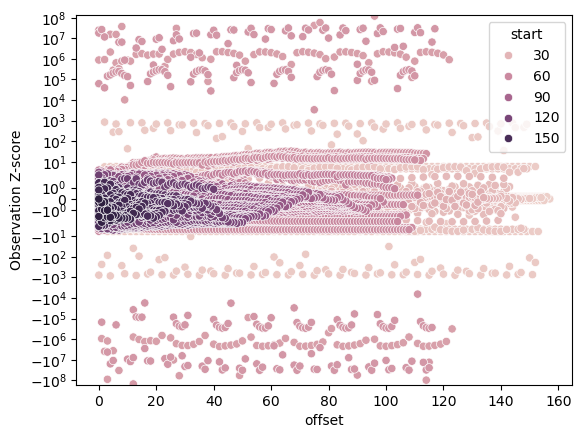

In [293]:
sns.scatterplot(prediction_df, x='offset', y='Observation Z-score', hue='start')
plt.yscale('symlog')

# Log Likelihood of Observations

In [745]:
def std_kernel(t, w):
    return abs(np.sum([w[i]*t**i for i in range(len(w))], axis=0))

def gaussian(x, std=1, mu=0):
    # PDF of gaussian distribution
    return (1/(std*np.sqrt(np.pi*2))*np.exp((-1/2)*(((x-mu)/std)**2)))

def log_gaussian(x, std=1, mu=0):
    # Calculate log probablity directly to get around precision limitations
   # std = np.ma.masked_less_equal(std, 0)
    mask = std<=0
    std = abs(std)

    info = np.finfo(np.float64)
    std[std==0] = info.eps
    #std[mask] = np.nan
    
    logprob =  (-np.log(std) - 0.5*np.log(2*np.pi) - 0.5*(((x-mu)/std)**2))
    #logprob[mask] = -np.inf
    return logprob
  #  return logprob.filled(-np.inf)
    

def maximise_likelihood(w, x, mu, t):
    std = std_kernel(t, w)
    logprobs = log_gaussian(x, std=std, mu=mu)
    
    return -np.sum(logprobs[~np.isinf(logprobs)])

def constrain_std(w, t):
   # t = np.arange(200)
    std = std_kernel(t, w)
    return np.sum(std<=0)

In [296]:
test_df = copy.deepcopy(prediction_df)
test_df = test_df[test_df.offset<10]

In [297]:
logprobs = log_gaussian(test_df['Observed'], std=test_df.Std, mu=test_df['value'])
arma_std_likelihood = np.sum(logprobs[~np.isinf(logprobs)])
print( np.sum(np.isinf(logprobs)))
print( np.sum(logprobs[~np.isinf(logprobs)]))

0
-6656789100440147.0


# Maximising Log-Likelihood

In [748]:
class Prediction_Set():
    def __init__(self, df, limit_offset=10, w0=None):
        self.df = df

        self.prediction_set = (self.df.offset >=0)
        self.prediction_df = df[self.prediction_set].dropna()

        self.test_df = copy.deepcopy(self.prediction_df)
        self.test_df = self.test_df[self.test_df.offset<limit_offset] # Was 10

        if w0 is None:
            offset_std = scipy.stats.linregress(self.test_df['offset'], self.test_df['Std'])
            self.w0 = [offset_std.intercept, offset_std.slope,0]
        else: self.w0 =w0

    def optimise_likelihood(self, w0=None, method='Nelder-Mead', verbose=True, plot_path=True):
        if w0 is None:
            w0 = self.w0

        if method=='Differential Evolution':
            self.bound = 10000000
            res = scipy.optimize.differential_evolution(self.maximise_likelihood, 
                                          [(-self.bound, self.bound) for p in w0])
            self.res = Results(res, self)
            self.w0 = res.x                              
        else:
            res = scipy.optimize.minimize(self.maximise_likelihood, 
                                    w0, 
                                    constraints=[{'fun':self.constrain_std, 'args':([self.test_df['offset']]), 'type':'eq'}],
                                    method=method,
                                    options={'maxiter':20000, 'return_all':True})
            self.res = Results(res, self)
            if plot_path:
                self.res.plot_result_path()
                self.w0 = self.res.all_simplex.loc[self.res.all_simplex["Performance"].argmin(), self.res.param_cols]
            
        if verbose:
            print(res)
            
        return res

    def maximise_likelihood(self, w):
        std = std_kernel(self.test_df['offset'], w)
        logprobs = log_gaussian(self.test_df['Observed'], std=std, mu=self.test_df['value'])
        
        return -np.sum(logprobs[~np.isinf(logprobs)])

    def constrain_std(self, w, t):

        std = std_kernel(t, w)
        return np.sum(std<=0)

    def apply_estimate(self):
        self.prediction_df = self.apply_estimate_to_df(self.prediction_df)
        self.test_df = self.apply_estimate_to_df(self.test_df)

    def apply_estimate_to_df(self, df):
        df["Optimised Std"] = std_kernel(df['offset'], self.w0)
        df["New Z-score"] = (df["Observed"]-df['value'])/df['Optimised Std'] 
        df["Start Z-score"] = (df["Start Observed"]-df['value'])/df['Optimised Std'] 
        df["Observed Higher"] = df["Observed"] > df["Start Observed"]
        return df

In [749]:
class Results():
    def __init__(self, res, source):
        self.res = res
        
        
        self.source=source
        

    def plot_result_path(self):
        self.simplex = pd.DataFrame(self.res.allvecs)
        self.param_cols = self.simplex.columns
        
        for i in self.simplex.index:
            self.simplex.loc[i, "Performance"] = self.source.maximise_likelihood(self.simplex.iloc[i][self.param_cols])
        self.all_simplex = self.simplex
        
        g = sns.PairGrid(self.simplex[self.param_cols], corner=True)
        g.map_lower(self.pair_results)
        
        
        plt.tight_layout()
        
            
        g.map_diag(self.performance_diag, performance = self.simplex["Performance"])


    def pair_results(self, x, y, color='C0', label=None, **kwargs):
        plt.gca().plot(x, y, color=color, label=label)
        plt.gca().scatter(x.iloc[-1], y.iloc[-1], marker='*', c='goldenrod', zorder=10)
    
        combo = [x.name, y.name]

        self.interpolate_grid(self.simplex, combo, plt.gca())

    def performance_diag(self, x, color='C0', label=None, **kwargs):
        plt.gca().plot(x, kwargs["performance"])
        plt.gca().set_yscale('log')

    def interpolate_grid(self, simplex, cols, ax):
        yl = ax.get_ylim()
        y = np.linspace(*ax.get_ylim())
        x = np.linspace(*ax.get_xlim())
        [X, Y]=np.meshgrid(x,y)
        new_simplex = pd.DataFrame(index=np.arange(len(X.reshape(-1))), columns=self.param_cols)
        new_simplex[self.param_cols] = self.res.x
        new_simplex[cols[0]] = X.reshape(-1)
        new_simplex[cols[1]] = Y.reshape(-1)
    # print(new_simplex)
        Z = np.zeros_like(X.reshape(-1))
        for i in new_simplex.index:
            Z[i] = self.source.maximise_likelihood(new_simplex.iloc[i])
        found_best = self.res.fun
        levels = np.geomspace(Z.min(), np.quantile(Z, 0.5), num=10)
        levels = np.sort([*levels, found_best, Z.max()])
        c = ax.contourf(X, Y, Z.reshape(X.shape), norm=mpl.colors.LogNorm(vmin=Z.min(), vmax=np.quantile(Z, 0.5)), levels=levels, cmap='YlGnBu')
        plt.colorbar(c)

        Z_best = Z.argmin()
        overall_best = new_simplex.iloc[Z_best]
        ax.title.set_text(f"L* = {Z[Z_best]:.2f}, (Grid Search)")
        if Z[Z_best] > found_best:
            overall_best = self.res.x
            ax.title.set_text(f"L* = {found_best:.2f}, (Algorithm)")
        
        ax.scatter(new_simplex[cols[0]], new_simplex[cols[1]], s=5, c='w', alpha=0.1)
        ax.scatter(overall_best[cols[0]], overall_best[cols[1]], marker='*', c='r')

        new_simplex['Performance'] = Z
        
        self.all_simplex = pd.concat([self.all_simplex, new_simplex]).reset_index(drop=True)

             message: Optimization terminated successfully.
             success: True
                 fun: 24944.316369684588
                   x: [ 1.169e+05  3.937e+06 -4.091e+06]
                 nit: 14
                nfev: 683
          population: [[ 1.169e+05  3.937e+06 -4.091e+06]
                       [ 2.503e+06  2.786e+06 -6.373e+06]
                       ...
                       [ 4.985e+05  9.908e+06 -4.973e+06]
                       [-3.818e+06  7.825e+06 -4.121e+06]]
 population_energies: [ 2.494e+04  2.611e+04 ...  2.526e+04  2.547e+04]
                 jac: [-2.183e-03 -3.720e-03 -3.720e-03]


C:\Users\Meredith\AppData\Local\Temp\ipykernel_15424\3000751313.py:27: RuntimeWarning: Method Nelder-Mead cannot handle constraints.
  res = scipy.optimize.minimize(self.maximise_likelihood,


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 23784.4569868459
             x: [ 5.798e+02  4.238e+06 -4.239e+06]
           nit: 388
          nfev: 738
 final_simplex: (array([[ 5.798e+02,  4.238e+06, -4.239e+06],
                       [ 5.798e+02,  4.238e+06, -4.239e+06],
                       [ 5.798e+02,  4.238e+06, -4.239e+06],
                       [ 5.798e+02,  4.238e+06, -4.239e+06]]), array([ 2.378e+04,  2.378e+04,  2.378e+04,  2.378e+04]))
       allvecs: [array([ 1.169e+05,  3.937e+06, -4.091e+06]), array([ 1.227e+05,  3.937e+06, -4.091e+06]), array([ 1.227e+05,  3.937e+06, -4.091e+06]), array([ 1.227e+05,  3.937e+06, -4.091e+06]), array([ 1.189e+05,  3.995e+06, -4.093e+06]), array([ 1.197e+05,  3.965e+06, -4.070e+06]), array([ 1.197e+05,  3.965e+06, -4.070e+06]), array([ 1.209e+05,  3.954e+06, -4.087e+06]), array([ 1.194e+05,  3.976e+06, -4.087e+06]), array([ 1.193e+05,  3.958e+06, -4.085e+06]), array([ 1.19

C:\Users\Meredith\AppData\Local\Temp\ipykernel_15424\3000751313.py:27: RuntimeWarning: Method Nelder-Mead cannot handle constraints.
  res = scipy.optimize.minimize(self.maximise_likelihood,


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 23784.4569868459
             x: [ 5.798e+02  4.238e+06 -4.239e+06]
           nit: 103
          nfev: 218
 final_simplex: (array([[ 5.798e+02,  4.238e+06, -4.239e+06],
                       [ 5.798e+02,  4.238e+06, -4.239e+06],
                       [ 5.798e+02,  4.238e+06, -4.239e+06],
                       [ 5.798e+02,  4.238e+06, -4.239e+06]]), array([ 2.378e+04,  2.378e+04,  2.378e+04,  2.378e+04]))
       allvecs: [array([ 5.798e+02,  4.238e+06, -4.239e+06]), array([ 5.798e+02,  4.238e+06, -4.239e+06]), array([ 5.798e+02,  4.238e+06, -4.239e+06]), array([ 5.798e+02,  4.238e+06, -4.239e+06]), array([ 5.798e+02,  4.238e+06, -4.239e+06]), array([ 5.798e+02,  4.238e+06, -4.239e+06]), array([ 5.798e+02,  4.238e+06, -4.239e+06]), array([ 5.798e+02,  4.238e+06, -4.239e+06]), array([ 5.798e+02,  4.238e+06, -4.239e+06]), array([ 5.798e+02,  4.238e+06, -4.239e+06]), array([ 5.79

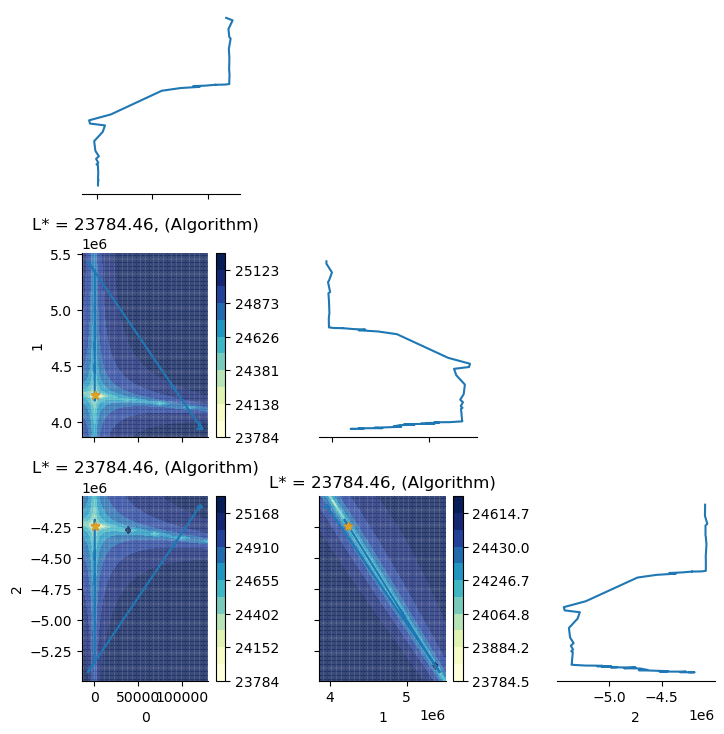

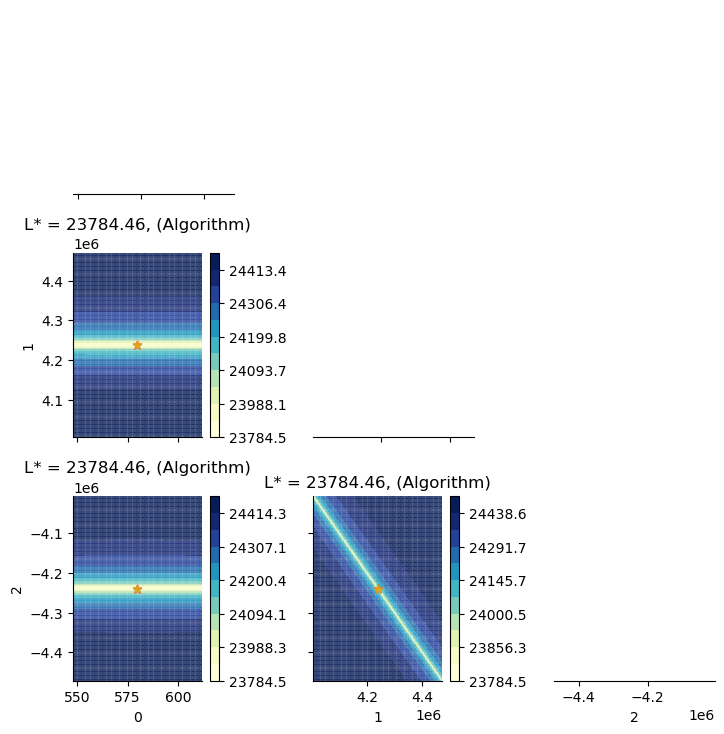

In [750]:
price = Prediction_Set(df)
res = price.optimise_likelihood(method='Differential Evolution')
res1 = price.optimise_likelihood()
res2 = price.optimise_likelihood()



             message: Optimization terminated successfully.
             success: True
                 fun: 21451.598404010496
                   x: [-9.261e+05  1.232e+06 -3.102e+05]
                 nit: 28
                nfev: 1421
          population: [[-9.251e+05  1.232e+06 -3.168e+05]
                       [-9.819e+05  1.315e+06 -2.952e+05]
                       ...
                       [-8.805e+05  1.246e+06 -3.511e+05]
                       [-1.116e+06  1.552e+06 -4.303e+05]]
 population_energies: [ 2.145e+04  2.197e+04 ...  2.193e+04  2.200e+04]
                 jac: [ 0.000e+00  0.000e+00  0.000e+00]


C:\Users\Meredith\AppData\Local\Temp\ipykernel_15424\3000751313.py:27: RuntimeWarning: Method Nelder-Mead cannot handle constraints.
  res = scipy.optimize.minimize(self.maximise_likelihood,


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 21409.843654545642
             x: [-7.532e+05  1.002e+06 -2.527e+05]
           nit: 134
          nfev: 283
 final_simplex: (array([[-7.532e+05,  1.002e+06, -2.527e+05],
                       [-7.532e+05,  1.002e+06, -2.527e+05],
                       [-7.532e+05,  1.002e+06, -2.527e+05],
                       [-7.532e+05,  1.002e+06, -2.527e+05]]), array([ 2.141e+04,  2.141e+04,  2.141e+04,  2.141e+04]))
       allvecs: [array([-9.261e+05,  1.232e+06, -3.102e+05]), array([-9.261e+05,  1.232e+06, -3.102e+05]), array([-9.261e+05,  1.232e+06, -3.102e+05]), array([-9.261e+05,  1.232e+06, -3.102e+05]), array([-9.261e+05,  1.232e+06, -3.102e+05]), array([-9.261e+05,  1.232e+06, -3.102e+05]), array([-9.261e+05,  1.232e+06, -3.102e+05]), array([-9.261e+05,  1.232e+06, -3.102e+05]), array([-9.261e+05,  1.232e+06, -3.102e+05]), array([-9.261e+05,  1.232e+06, -3.102e+05]), array([-9.

C:\Users\Meredith\AppData\Local\Temp\ipykernel_15424\3000751313.py:27: RuntimeWarning: Method Nelder-Mead cannot handle constraints.
  res = scipy.optimize.minimize(self.maximise_likelihood,


ValueError: Contour levels must be increasing

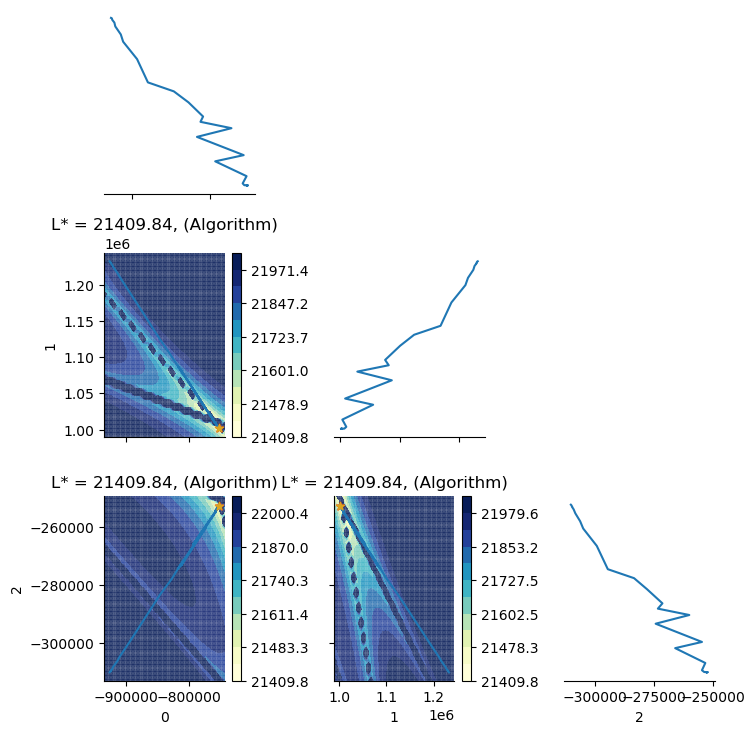

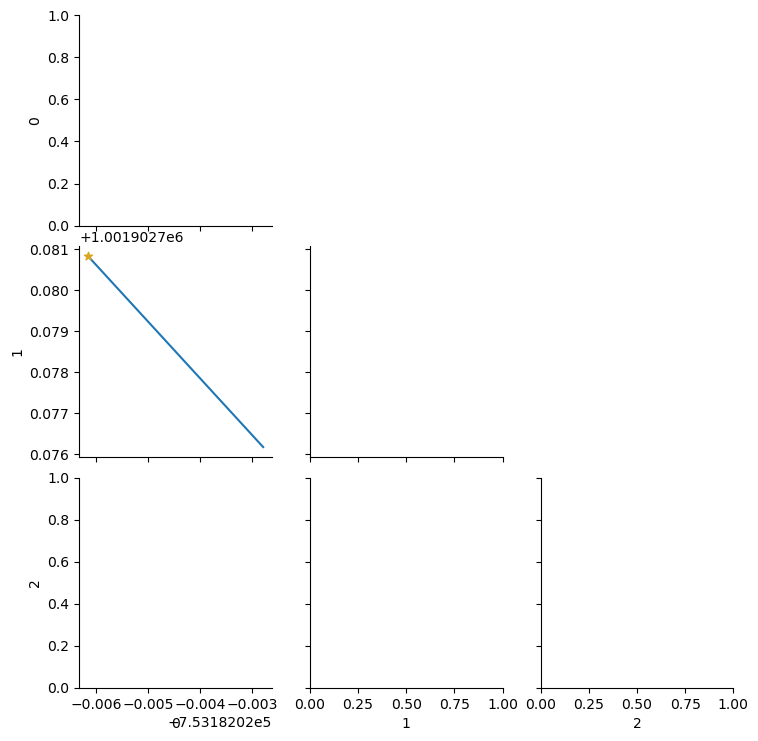

In [751]:
volume = Prediction_Set(vol_df)
res_vol = volume.optimise_likelihood(method='Differential Evolution')
res_vol1 = volume.optimise_likelihood(w0=res_vol.x)
res_vol2 = volume.optimise_likelihood()

In [764]:
price.apply_estimate()
volume.apply_estimate()

In [ ]:
import pyomo.environ as pyo
from pyomo.opt import SolverFactory

model = pyo.AbstractModel()
model.name = 'Likelihood Maximisation'

# note boundaries of variables and initial condition $x_0=[-2,2]$
model.x1 = pyo.Var(bounds=(-2,3), initialize=-2)
model.x2 = pyo.Var(bounds=(-2,2), initialize=2)
model.x3 = pyo.Var(bounds=(-2,3), initialize=-2)
model.x4 = pyo.Var(bounds=(-2,2), initialize=2)

def rosenbrock(model):
    f = (1.0-model.x1)**2 + 100.0*(model.x2 - model.x1**2)**2
    return f

def ineqconstr(model):
    return model.x2 >= model.x1+1

model.obj = pyo.Objective(rule=rosenbrock, sense=pyo.minimize)
model.constraint = pyo.Constraint(rule=ineqconstr)

In [ ]:
import io
 
# declare a dummy file
dummy_file = io.StringIO() #we create a in-memory text stream

# create an instance of the problem
maxlikeproblem = model.create_instance()
# this is to access Lagrange multipliers (dual variables)
maxlikeproblem.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)

# define solver
opt = pyo.SolverFactory('ipopt') # we can use other solvers here as well

results = opt.solve(maxlikeproblem, tee=True, logfile = "name.csv") 

# show results

maxlikeproblem.display(ostream=dummy_file)

    ipopt


ApplicationError: No executable found for solver 'ipopt'

# Comparing Z-scores of observations

In [483]:
test_df["Optimised Std"] = std_kernel(test_df['offset'], price.w0)
test_df["New Z-score"] = (test_df["Observed"]-test_df['value'])/test_df['Optimised Std'] 

,index,lower,upper,value,start,offset,period,Observed,Rank,Observed Rank,error,rank_error,Absolute Error,Absolute Rank Error,Std,Observation Z-score,Start Observed,Higher,Optimised Std,New Z-score
686,14,-1.243484e+02,1.067423e+03,4.715373e+02,14,0,14,1600.000,77.0,36.5,-1.128463e+03,40.5,1.128463e+03,40.5,304.023313,3.711764,1600.0,False,5.798221e+02,1.946222
687,15,7.195972e+03,1.363502e+04,1.041550e+04,14,1,15,1600.000,92.0,36.5,8.815497e+03,55.5,8.815497e+03,55.5,1642.615078,-5.366746,1600.0,True,8.295652e+02,-10.626648
688,16,-7.156474e+04,-3.407917e+04,-5.282195e+04,14,2,16,1600.000,76.0,36.5,-5.442195e+04,39.5,5.442195e+04,39.5,9562.644139,5.691099,1600.0,False,-3.726548e+06,-0.014604
689,17,2.090931e+05,4.191917e+05,3.141424e+05,14,3,17,1660.000,93.0,49.0,3.124824e+05,44.0,3.124824e+05,44.0,53596.566114,-5.830269,1600.0,True,-5.627766e+06,0.055525
690,18,-2.352902e+06,-1.173130e+06,-1.763016e+06,14,4,18,1654.165,75.0,48.0,-1.764670e+06,27.0,1.764670e+06,27.0,300962.394962,5.863424,1600.0,False,-1.490371e+05,-11.840480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19115,131,4.869456e+03,6.587289e+03,5.728373e+03,123,8,131,4350.000,131.0,116.0,1.378373e+03,15.0,1.378373e+03,15.0,438.222575,-3.145371,4950.0,True,2.066411e+08,-0.000007
19116,132,4.923808e+03,6.838428e+03,5.881118e+03,123,9,132,4350.000,133.0,116.0,1.531118e+03,17.0,1.531118e+03,17.0,488.423536,-3.134817,4950.0,True,3.323263e+08,-0.000005
19278,126,4.513464e+03,5.484795e+03,4.999130e+03,124,2,126,4225.000,122.0,113.0,7.741299e+02,9.0,7.741299e+02,9.0,247.788502,-3.124156,4500.0,True,-3.726548e+06,0.000208
23502,150,4.737931e+03,5.591714e+03,5.164823e+03,149,1,150,4500.000,149.0,124.5,6.648226e+02,24.5,6.648226e+02,24.5,217.801606,-3.052423,5000.0,True,8.295652e+02,-0.801411


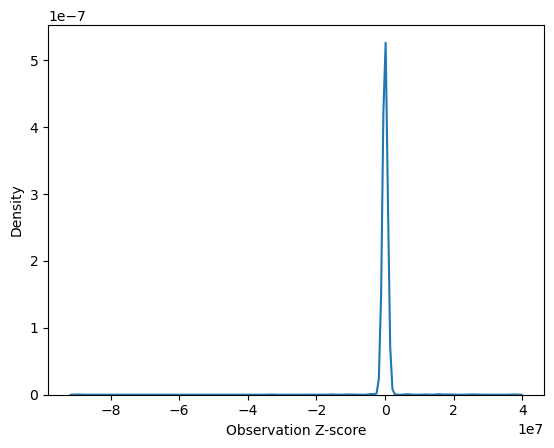

In [484]:
sns.kdeplot(test_df, x='Observation Z-score')
test_df[abs(test_df["Observation Z-score"])>3]

<AxesSubplot: xlabel='New Z-score', ylabel='Density'>

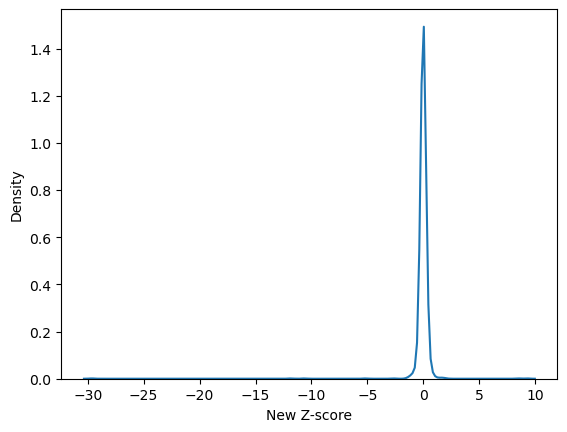

In [485]:
sns.kdeplot(test_df, x='New Z-score')

In [486]:
test_df[abs(test_df["New Z-score"])>3]

,index,lower,upper,value,start,offset,period,Observed,Rank,Observed Rank,error,rank_error,Absolute Error,Absolute Rank Error,Std,Observation Z-score,Start Observed,Higher,Optimised Std,New Z-score
687,15,7.195972e+03,1.363502e+04,1.041550e+04,14,1,15,1600.000,92.0,36.5,8.815497e+03,55.5,8.815497e+03,55.5,1.642615e+03,-5.366746e+00,1600.0,True,8.295652e+02,-10.626648
690,18,-2.352902e+06,-1.173130e+06,-1.763016e+06,14,4,18,1654.165,75.0,48.0,-1.764670e+06,27.0,1.764670e+06,27.0,3.009624e+05,5.863424e+00,1600.0,False,-1.490371e+05,-11.840480
694,22,-2.339851e+09,-1.168607e+09,-1.754229e+09,14,8,22,1648.500,73.0,40.0,-1.754230e+09,33.0,1.754230e+09,33.0,2.987868e+08,5.871177e+00,1600.0,False,2.066411e+08,8.489262
695,23,6.560588e+09,1.313603e+10,9.848312e+09,14,9,23,1690.000,96.0,50.0,9.848310e+09,46.0,9.848310e+09,46.0,1.677410e+09,-5.871141e+00,1600.0,True,3.323263e+08,-29.634455
855,15,4.588532e+03,4.603713e+03,4.596122e+03,15,0,15,1600.000,92.0,36.5,2.996122e+03,55.5,2.996122e+03,55.5,3.872536e+00,-7.736848e+02,1600.0,True,5.798221e+02,-5.167314
6432,48,-3.974307e+03,-3.974306e+03,-3.974306e+03,48,0,48,1400.000,60.0,20.5,-5.374306e+03,39.5,5.374306e+03,39.5,2.145832e-04,2.504533e+07,1100.0,False,5.798221e+02,9.268889


# Prediction Improvement

In [488]:
test_df["Start Z-score"] = (test_df["Start Observed"]-test_df['value'])/test_df['Optimised Std'] 
test_df["Observed Higher"] = test_df["Observed"] > test_df["Start Observed"]

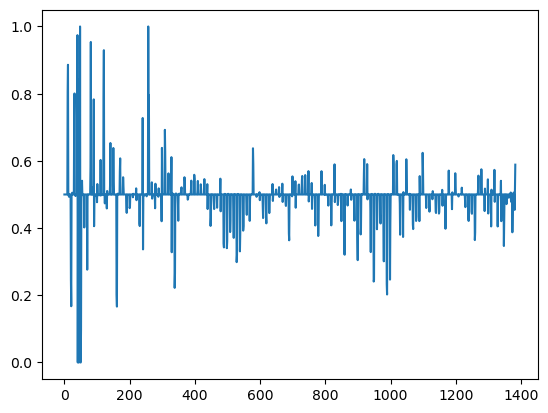

In [489]:
plt.plot(scipy.stats.norm.cdf(test_df["Start Z-score"]))

In [490]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import RocCurveDisplay

def make_confusion_matrix(obs, pred):
    conf_matrix = confusion_matrix(obs, pred)

    sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, fmt='.2%')

    RocCurveDisplay.from_predictions(obs, pred)

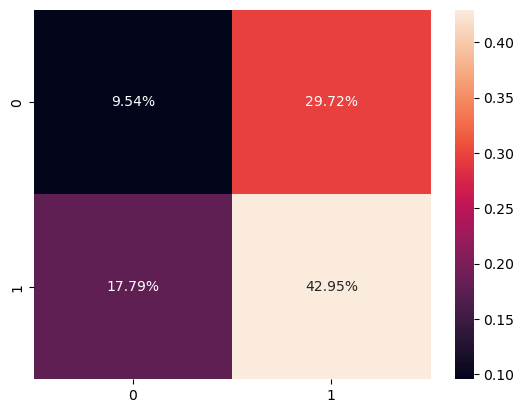

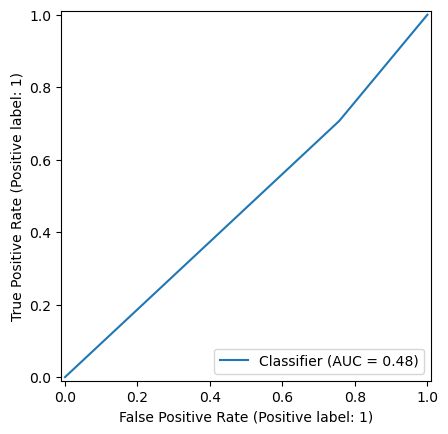

In [491]:
make_confusion_matrix(test_df['Observed Higher'], test_df['Higher'])

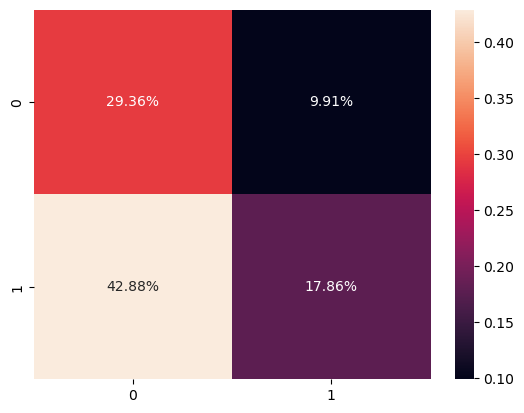

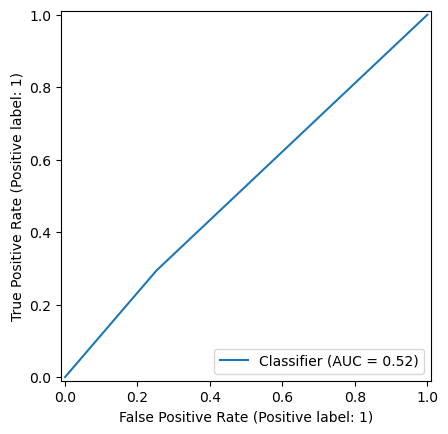

In [62]:
make_confusion_matrix(test_df['Observed Higher'], test_df['Start Z-score']>0)

(-3.0, 3.0)

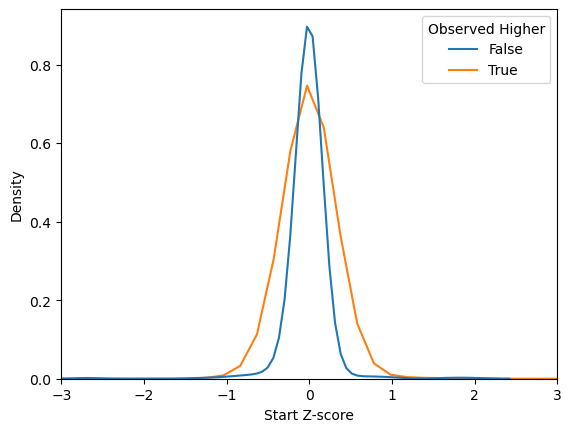

In [492]:
sns.kdeplot(test_df, hue='Observed Higher', x='Start Z-score')
plt.xlim(-3, 3)

In [493]:
hist, edges = np.histogram(test_df.loc[test_df['Observed Higher'], 'Start Z-score'], range=(-1, 1), bins=50)
hist2, _ =np.histogram(test_df.loc[~test_df['Observed Higher'], 'Start Z-score'], bins=edges)

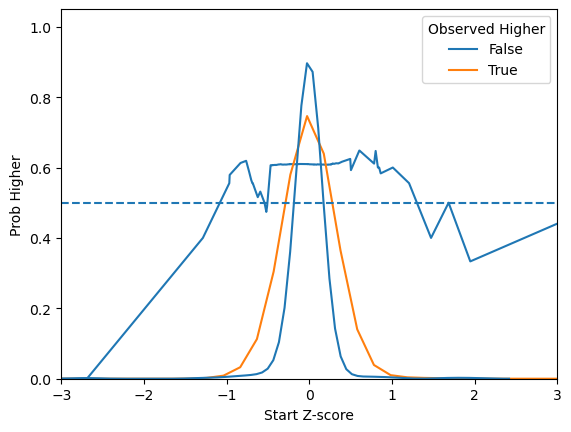

In [494]:
dist = 0.5
test_df["Prob Higher"] = test_df.apply(lambda x: test_df.loc[abs(test_df['Start Z-score']-x['Start Z-score'])<dist, 'Observed Higher'].mean(), axis=1)




sns.lineplot(test_df, x='Start Z-score', y='Prob Higher')
plt.xlim(-3, 3)

sns.kdeplot(test_df, hue='Observed Higher', x='Start Z-score')

plt.axhline(0.5, ls='--')

In [495]:
zscores = np.linspace(-3, 3)

zscore_df = pd.DataFrame(columns=['Z-Score', 'Probability Higher'])
zscore_df['Z-Score'] = zscores
zscore_df["Probability Higher"] = zscore_df.apply(lambda zscore:test_df.loc[train].loc[(abs(test_df['Start Z-score']-zscore['Z-Score'])<dist), 'Observed Higher'].mean(), axis=1)

zscore_df["Probability Higher"] = zscore_df.apply(lambda zscore:np.average(test_df.loc[train,'Observed Higher'], weights=1/abs(test_df.loc[train, 'Start Z-score']-zscore['Z-Score'])**2), axis=1)

(-3.0, 3.0)

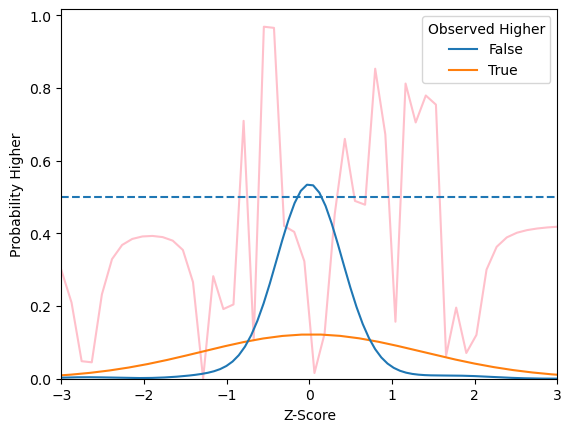

In [496]:
sns.lineplot(zscore_df, x='Z-Score', y='Probability Higher', c='pink')
sns.kdeplot(test_df.loc[train], hue='Observed Higher', x='Start Z-score')

plt.axhline(0.5, ls='--')
plt.xlim(-3, 3)


C:\Users\Meredith\AppData\Local\Temp\ipykernel_15424\2638970641.py:5: RuntimeWarning: invalid value encountered in divide
  plt.plot(centers, hist2/(hist+hist2))
C:\Users\Meredith\AppData\Local\Temp\ipykernel_15424\2638970641.py:6: RuntimeWarning: invalid value encountered in divide
  plt.plot(centers, hist/(hist+hist2))


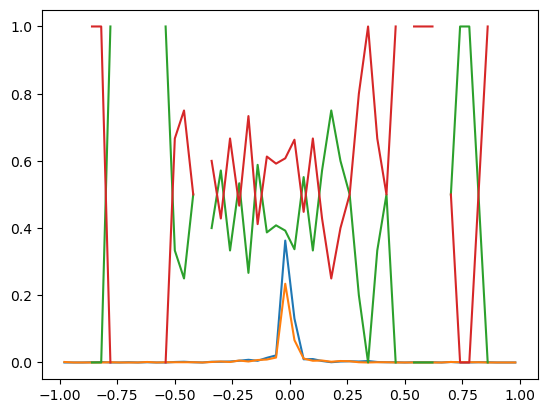

In [222]:
centers = (edges[1:] + edges[:-1])/2

plt.plot(centers, hist/np.sum(hist+hist2))
plt.plot(centers, hist2/np.sum(hist2+hist))
plt.plot(centers, hist2/(hist+hist2))
plt.plot(centers, hist/(hist+hist2))

In [220]:
test_df['Start Z-score'].std()

0.9871383304614405

<AxesSubplot: xlabel='Observed Higher', ylabel='Start Z-score'>

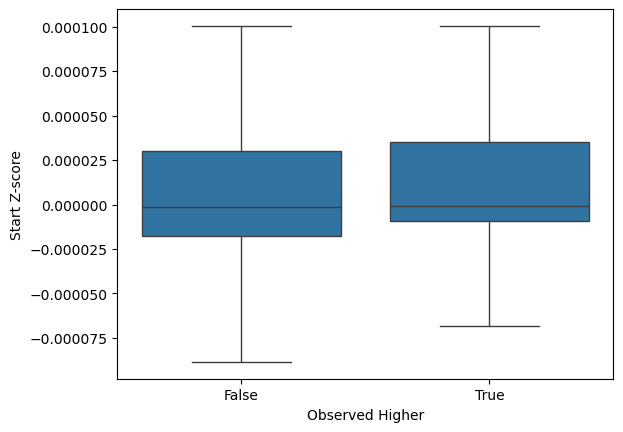

In [497]:
sns.boxplot(test_df, x='Observed Higher', y='Start Z-score', showfliers=False)

(-3.0, 3.0)

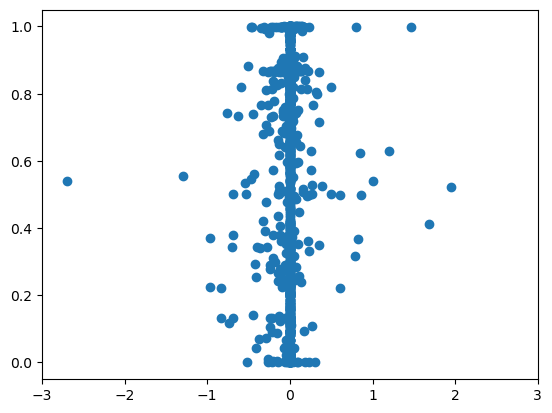

In [498]:
z_rolling =test_df.rolling(2000, on='Start Z-score', center=True, min_periods=0, win_type='gaussian')
higher_prob = z_rolling.mean(std=3)['Observed Higher'].dropna()

plt.scatter(test_df.loc[higher_prob.index, 'Start Z-score'], higher_prob)
plt.xlim(-3, 3)

In [499]:
bins = np.linspace(-1, 1)


<AxesSubplot: xlabel='Higher', ylabel='Start Z-score'>

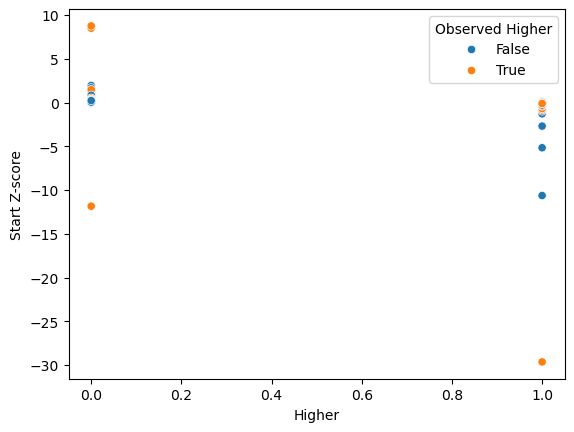

In [500]:
sns.scatterplot(test_df, x='Higher', y='Start Z-score', hue='Observed Higher')

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


(-3.0, 3.0)

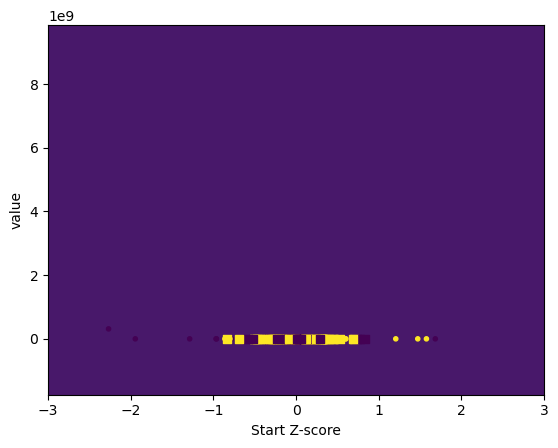

In [159]:
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split

n = 50
train = np.random.choice(test_df.index, n, replace=False)
train = test_df.index[test_df.period < n]
test = ~np.in1d(test_df.index, train)
X = test_df[['Start Z-score', 'value']]
Y = test_df['Observed Higher']
model = SVC(kernel='rbf', gamma=0.7, C=1, probability=True)
model.fit(X.loc[train].values, Y.loc[train].values)

fig, ax = plt.subplots()
DecisionBoundaryDisplay.from_estimator(model, X, ax=ax)

for filt, marker in zip([train, test], ['.', 's']):
    ax.scatter(X.iloc[:, 0][filt], X.iloc[:, 1][filt], c=Y[filt], marker=marker)

ax.set_xlim(-3, 3)

In [160]:
from sklearn.metrics import roc_auc_score

def test_prob_thresholds(model, X, Y):

    fig, ax = plt.subplots(2)
    sm = plt.cm.ScalarMappable(cmap="Spectral")
    for thresh in np.linspace(0, 1):
        RocCurveDisplay.from_predictions(Y, model.predict_proba(X.values)[:, 1]>thresh,ax=ax[0], color=sm.get_cmap()(thresh))
        ax[1].bar(thresh, roc_auc_score(Y, model.predict_proba(X.values)[:, 1]>thresh), width=[1/50], color=sm.get_cmap()(thresh))

    ax[0].legend().set_visible(False)
    plt.colorbar(sm, ax=ax[1])
    fig.tight_layout()

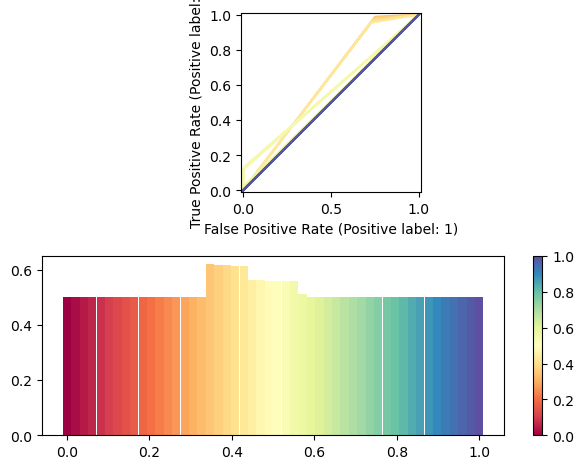

In [161]:
test_prob_thresholds(model, X, Y)

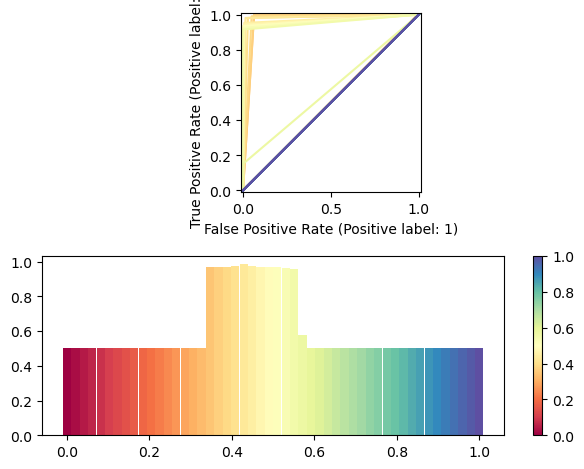

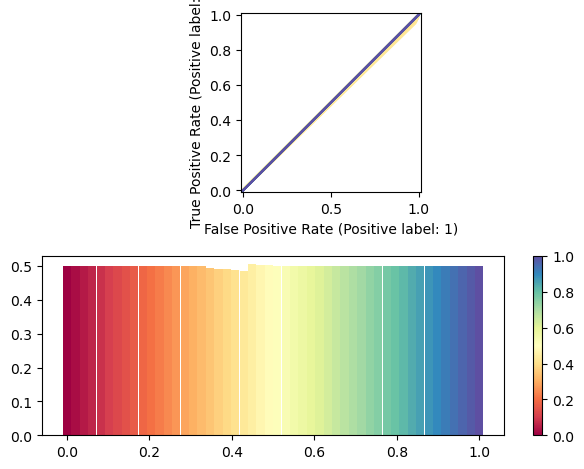

In [162]:
test_prob_thresholds(model, X.loc[train], Y.loc[train])
test_prob_thresholds(model, X.loc[test], Y.loc[test])

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


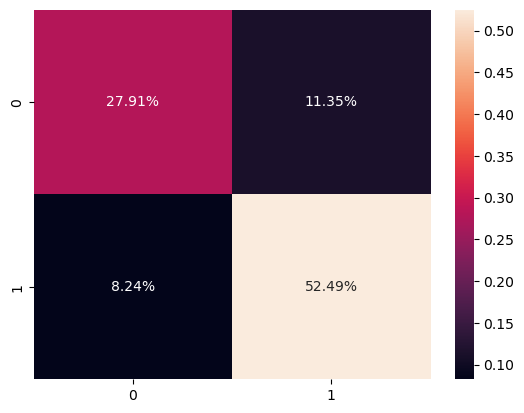

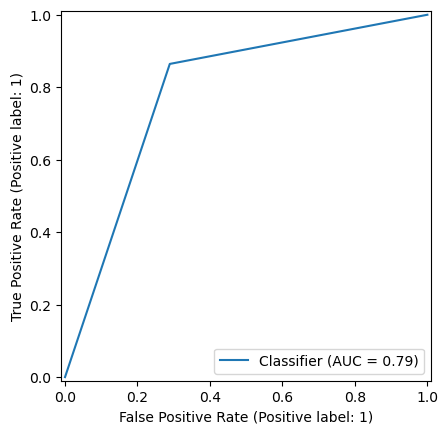

In [131]:

make_confusion_matrix(Y, model.predict_proba(X)[:, 1]>0.5)

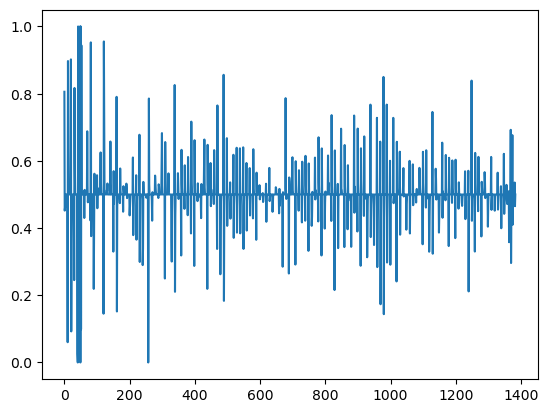

In [40]:
plt.plot(scipy.stats.norm.cdf(test_df["New Z-score"]))

[]

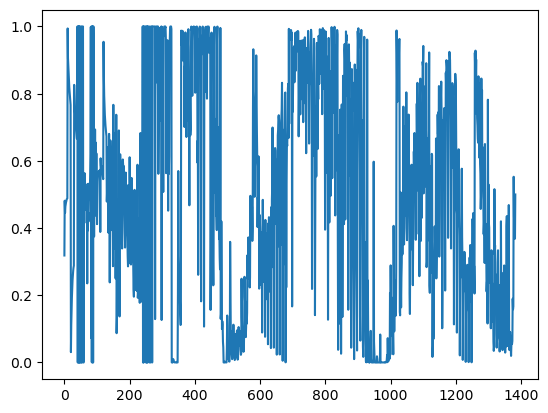

In [37]:
plt.plot(scipy.stats.norm.cdf(test_df["Observation Z-score"]))
plt.plot()

## More Estimation

In [504]:
filt = test_df.period == 100
logprobs = log_gaussian(test_df.loc[filt, 'Observed'], std=test_df.loc[filt, 'Optimised Std'], mu=test_df.loc[filt, 'value'])
-np.sum(logprobs[~np.isinf(logprobs)])


156.88038589793194

In [516]:
gaussian(x, std=std, mu=mu)

13708    1.200453e-09
13876    1.930605e-09
14044    3.436056e-09
14212    7.232009e-09
14380    2.184378e-08
14548   -2.676781e-06
14716   -7.088822e-08
14884   -1.070541e-07
15052    4.607775e-04
15220    6.262487e-04
dtype: float64

In [518]:

mus

array([   0.        ,   59.33505554,  118.67011108,  178.00516662,
        237.34022215,  296.67527769,  356.01033323,  415.34538877,
        474.68044431,  534.01549985,  593.35055539,  652.68561093,
        712.02066646,  771.355722  ,  830.69077754,  890.02583308,
        949.36088862, 1008.69594416, 1068.0309997 , 1127.36605524,
       1186.70111077, 1246.03616631, 1305.37122185, 1364.70627739,
       1424.04133293, 1483.37638847, 1542.71144401, 1602.04649955,
       1661.38155508, 1720.71661062, 1780.05166616, 1839.3867217 ,
       1898.72177724, 1958.05683278, 2017.39188832, 2076.72694386,
       2136.06199939, 2195.39705493, 2254.73211047, 2314.06716601,
       2373.40222155, 2432.73727709, 2492.07233263, 2551.40738817,
       2610.7424437 , 2670.07749924, 2729.41255478, 2788.74761032,
       2848.08266586, 2907.4177214 ])

In [524]:
gaussian(x, std=std, mu=mu)

13708    1.200453e-09
13876    1.930605e-09
14044    3.436056e-09
14212    7.232009e-09
14380    2.184378e-08
14548   -2.676394e-06
14716   -7.088821e-08
14884   -1.070541e-07
15052    1.034624e-06
15220    2.578579e-09
dtype: float64

In [537]:
test_df.period.describe()

count    1383.000000
mean       95.606652
std        44.049522
min        10.000000
25%        64.000000
50%        98.000000
75%       133.000000
max       167.000000
Name: period, dtype: float64

In [840]:
def update_prediction(period, df):
    filt = df.period == period
    std=df.loc[filt, 'Optimised Std']
    x = df.loc[filt, 'value']
    mus = np.linspace(0, x.max())
    likes = [np.sum(log_gaussian(x, std=std, mu=mu)) for mu in mus]
    best_mu = mus[np.argmax(likes)]
    return best_mu

In [841]:
def update_by_offset(df):
    for offset in df.offset.unique():
        offset_filt = df.offset==offset
        offset_df = df.loc[offset_filt, :]
        for period in offset_df.period.unique():
            
            
            #df.loc[offset_filt&(df.period==period), "Posterior Prediction"] = regress_error(df[(df.period==period)&(df.offset>=offset)])
            df.loc[offset_filt&(df.period==period), "Posterior Prediction"] = update_prediction(period, df[(df.offset>=offset)])

In [589]:
update_by_offset(test_df)

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\scipy\stats\_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\scipy\stats\_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\scipy\stats\_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\scipy\stats\_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\scipy\stats\_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + 

In [590]:
test_df["Posterior Higher"] = test_df["Posterior Prediction"] > test_df["Start Observed"]

In [593]:
test_df.loc[(test_df["Posterior Prediction"] - test_df["value"])!=0]

,index,lower,upper,value,start,offset,period,Observed,Rank,Observed Rank,...,Observation Z-score,Start Observed,Higher,Optimised Std,New Z-score,Start Z-score,Observed Higher,Prob Higher,Posterior Prediction,Posterior Higher
179,11,299.427575,1700.572425,1000.000000,11,0,11,1900.000000,157.0,58.0,...,2.517941,1500.0,False,5.798221e+02,1.552200,0.862334,True,0.583333,1346.938776,False
180,12,-1066.527564,2066.527564,500.000000,11,1,12,1550.000000,156.0,33.0,...,1.313734,1500.0,False,8.295652e+02,1.265723,1.205451,True,0.555556,489.795918,False
181,13,-2621.301987,2621.301987,0.000000,11,2,13,1600.000000,155.0,36.5,...,1.196352,1500.0,False,-3.726548e+06,-0.000429,-0.000403,True,0.609212,612.244898,False
182,14,-4337.193201,3337.193201,-500.000000,11,3,14,1600.000000,154.0,36.5,...,1.072659,1500.0,False,-5.627766e+06,-0.000373,-0.000355,True,0.609212,2000.000000,True
183,15,-6195.584155,4195.584155,-1000.000000,11,4,15,1600.000000,153.0,36.5,...,0.980833,1500.0,False,-1.490371e+05,-0.017445,-0.016774,True,0.609955,0.000000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26206,166,4241.088122,5090.833684,4665.960903,165,1,166,4630.000000,137.0,137.0,...,-0.165893,4600.0,True,8.295652e+02,-0.043349,-0.079513,True,0.610082,4654.080897,True
26207,167,4075.376597,5046.605095,4560.990846,165,2,167,4499.970344,133.0,118.0,...,-0.246286,4600.0,False,-3.726548e+06,0.000016,-0.000010,False,0.609212,4982.137654,True
26374,166,4340.910318,5022.584046,4681.747182,166,0,166,4630.000000,138.0,137.0,...,-0.297575,4615.0,True,5.798221e+02,-0.089247,-0.115117,True,0.610082,4654.080897,True
26375,167,4149.303170,4995.698088,4572.500629,166,1,167,4499.970344,133.0,118.0,...,-0.335917,4615.0,False,8.295652e+02,-0.087432,0.051231,False,0.608631,4548.908293,False


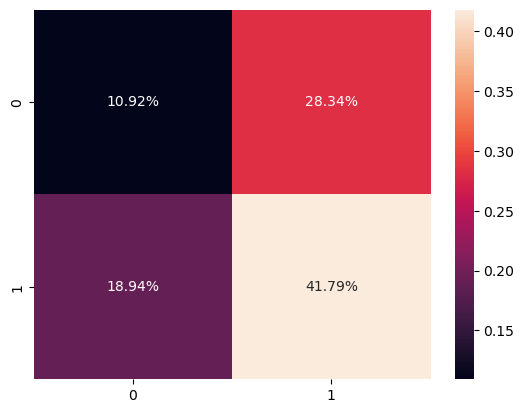

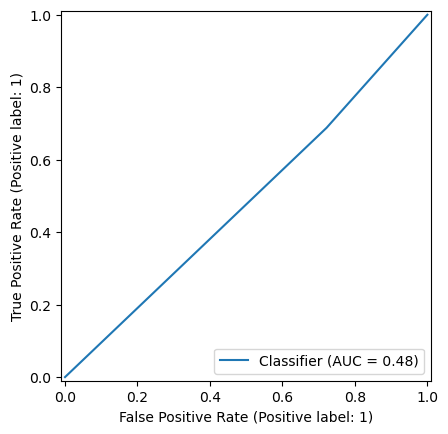

In [592]:
make_confusion_matrix(test_df['Observed Higher'], test_df['Posterior Higher'])

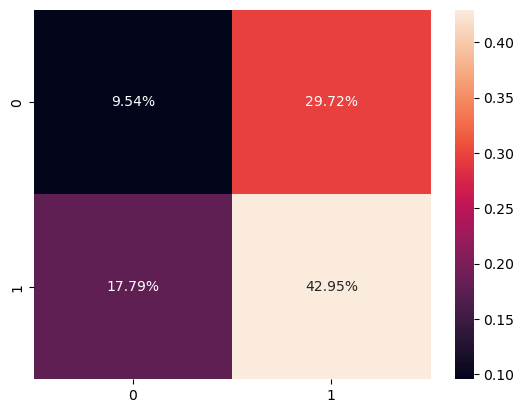

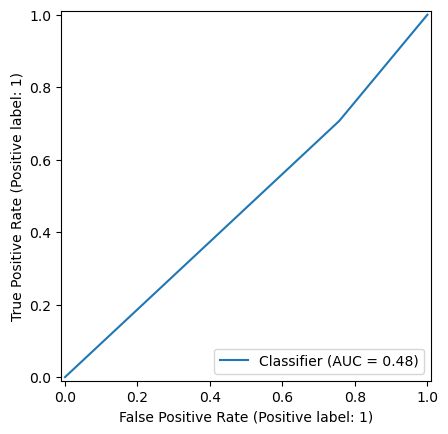

In [548]:
make_confusion_matrix(test_df['Observed Higher'], test_df['Higher'])

In [557]:
test_df

,index,lower,upper,value,start,offset,period,Observed,Rank,Observed Rank,...,Observation Z-score,Start Observed,Higher,Optimised Std,New Z-score,Start Z-score,Observed Higher,Prob Higher,Posterior Prediction,Posterior Higher
10,10,-75.687426,4075.687426,2000.000000,10,0,10,1500.000000,83.0,29.5,...,-0.472133,2000.0,False,5.798221e+02,-0.862334,0.000000,False,0.609212,2000.000000,False
11,11,-2207.247631,6207.247631,2000.000000,10,1,11,1900.000000,83.0,58.0,...,-0.046586,2000.0,False,8.295652e+02,-0.120545,0.000000,False,0.609212,2000.000000,False
12,12,-4411.817367,8411.817367,2000.000000,10,2,12,1550.000000,83.0,33.0,...,-0.137559,2000.0,False,-3.726548e+06,0.000121,-0.000000,False,0.609212,2000.000000,False
13,13,-6687.573032,10687.573032,2000.000000,10,3,13,1600.000000,83.0,36.5,...,-0.090244,2000.0,False,-5.627766e+06,0.000071,-0.000000,False,0.609212,2000.000000,False
14,14,-9032.793902,13032.793902,2000.000000,10,4,14,1600.000000,83.0,36.5,...,-0.071061,2000.0,False,-1.490371e+05,0.002684,-0.000000,False,0.609212,2000.000000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26206,166,4241.088122,5090.833684,4665.960903,165,1,166,4630.000000,137.0,137.0,...,-0.165893,4600.0,True,8.295652e+02,-0.043349,-0.079513,True,0.610082,4665.960903,True
26207,167,4075.376597,5046.605095,4560.990846,165,2,167,4499.970344,133.0,118.0,...,-0.246286,4600.0,False,-3.726548e+06,0.000016,-0.000010,False,0.609212,4560.990846,False
26374,166,4340.910318,5022.584046,4681.747182,166,0,166,4630.000000,138.0,137.0,...,-0.297575,4615.0,True,5.798221e+02,-0.089247,-0.115117,True,0.610082,4681.747182,True
26375,167,4149.303170,4995.698088,4572.500629,166,1,167,4499.970344,133.0,118.0,...,-0.335917,4615.0,False,8.295652e+02,-0.087432,0.051231,False,0.608631,4572.500629,False


In [580]:
def regress_error(df):
    # Estimate value using regression of previous predictions
    res = scipy.stats.linregress(df.offset, df.value)
    return res.intercept - res.slope # model offset of -1, aka accurate

In [615]:
old_test_df = copy.deepcopy(test_df)

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\scipy\stats\_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\scipy\stats\_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\scipy\stats\_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


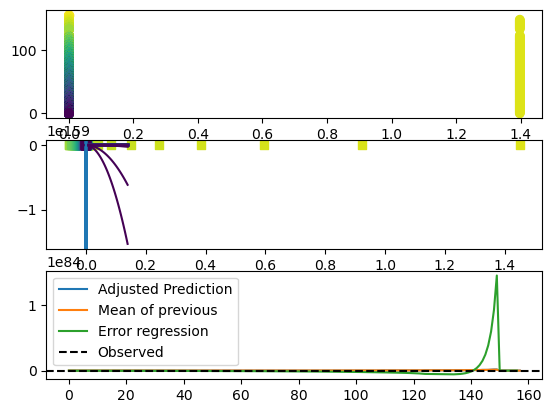

In [657]:
test_df = volume.prediction_df
pfilt = test_df.period == 167
fig, ax = plt.subplots(3)

norm = mpl.colors.Normalize(vmin=test_df.loc[pfilt].offset.min(), vmax=test_df.loc[pfilt].offset.max())
cmap = cm.ScalarMappable(norm=norm, cmap='viridis')

mus_found = []
means_found = []
regs_found = []

for offset in test_df.loc[pfilt, 'offset'].unique():
    filt = pfilt&(test_df.offset>=offset)
    std=test_df.loc[filt, 'Optimised Std']
    x=test_df.loc[filt, 'value']
    mus = np.linspace(0, x.max())
    likes = [np.sum(log_gaussian(x, std=std, mu=mu)) for mu in mus]

    
    #for mu in mus:
        #ax[0].scatter(mu, np.sum(((x-mu)/(std))**2))
        #ax[1].scatter(mu, np.sum(log_gaussian(x, std=std, mu=mu)))
    ax[0].scatter(x, np.repeat(offset, len(x)), c=cmap.get_cmap()(norm(test_df.loc[filt, 'offset'])))

    ax[1].plot(mus, likes, color=cmap.get_cmap()(norm(offset)))
    ax[1].scatter(mus[np.argmax(likes)], likes[np.argmax(likes)], color=cmap.get_cmap()(norm(offset)))
    ax[1].scatter(x.mean(), 1, marker='x', color=cmap.get_cmap()(norm(offset)))
    ax[1].axvline(test_df.loc[filt, 'Observed'].mean())

    reg_pred = regress_error(test_df.loc[filt])
    ax[1].scatter(reg_pred, 0, marker='s', color=cmap.get_cmap()(norm(offset)))
    regs_found.append(reg_pred)
    mus_found.append(mus[np.argmax(likes)])
    means_found.append(x.mean())
ax[2].plot(test_df.loc[pfilt, 'offset'].unique(), mus_found, label="Adjusted Prediction")
ax[2].plot(test_df.loc[pfilt, 'offset'].unique(), means_found, label="Mean of previous")
ax[2].plot(test_df.loc[pfilt, 'offset'].unique(), regs_found, label="Error regression")

ax[2].axhline(test_df.loc[filt, 'Observed'].mean(), label='Observed', ls='--', c='k')
ax[2].legend()

<AxesSubplot: >

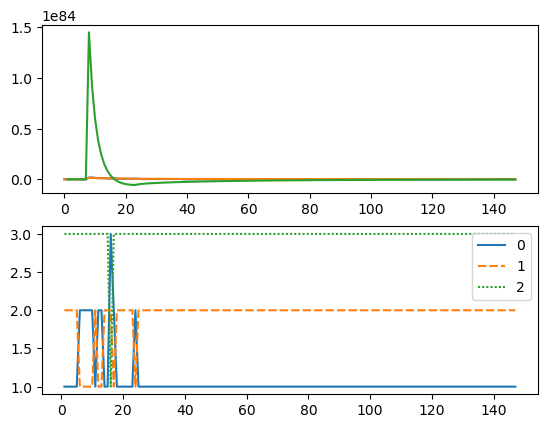

In [656]:
fig, ax = plt.subplots(2)
real_val = test_df.loc[filt, 'Observed'].mean()
ax[0].plot(np.array(mus_found)-real_val, label="Adjusted Prediction")
ax[0].plot(np.array(means_found)-real_val, label="Mean of previous")
ax[0].plot(np.array(regs_found)-real_val, label="Error regression")

#ax[0].axhline(real_val, label='Observed', ls='--', c='k')

ranks= scipy.stats.rankdata(abs(np.array([mus_found, means_found, regs_found])-real_val), axis=0)
sns.lineplot(ranks.T, ax=ax[1])

In [654]:
abs(np.array([mus_found, means_found, regs_found])-real_val)

array([[1.62021870e+05, 1.65445821e+05, 4.38079727e+04, 4.16214574e+04,
        1.09614636e+03, 1.09614636e+03, 2.50553552e+59, 2.19234358e+59,
        1.71111692e+82, 1.71111692e+82, 1.42593076e+82, 1.14074461e+82,
        1.14074461e+82, 1.14074461e+82, 8.55558459e+81, 8.55558459e+81,
        8.55558459e+81, 8.55558459e+81, 5.70372306e+81, 5.70372306e+81,
        5.70372306e+81, 5.70372306e+81, 5.70372306e+81, 5.70372306e+81,
        5.70372306e+81, 2.85186153e+81, 2.85186153e+81, 2.85186153e+81,
        2.85186153e+81, 2.85186153e+81, 2.85186153e+81, 2.85186153e+81,
        2.85186153e+81, 2.85186153e+81, 2.85186153e+81, 2.85186153e+81,
        2.85186153e+81, 2.85186153e+81, 2.85186153e+81, 1.09614636e+03,
        1.09614636e+03, 1.09614636e+03, 1.09614636e+03, 1.09614636e+03,
        1.09614636e+03, 1.09614636e+03, 1.09614636e+03, 1.09614636e+03,
        1.09614636e+03, 1.09614636e+03, 1.09614636e+03, 1.09614636e+03,
        1.09614636e+03, 1.09614636e+03, 1.09614636e+03, 1.096146

<AxesSubplot: >

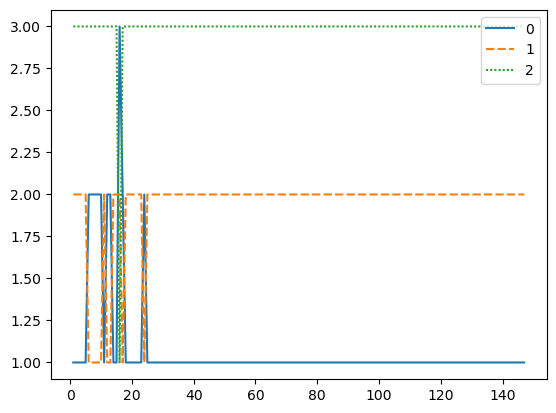

In [621]:
volume.df[volume.df.offset <-1].value.describe()

count    13825.000000
mean        30.852164
std       1063.339452
min      -1387.825578
25%       -729.358200
50%       -156.323807
75%        388.152694
max       4056.951877
Name: value, dtype: float64

In [632]:
volume.test_df.describe()

,index,lower,upper,value,start,offset,period,Observed,Rank,Observed Rank,error,rank_error,Absolute Error,Absolute Rank Error,Std,Observation Z-score,Start Observed,Optimised Std,New Z-score,Start Z-score
count,1435.000000,1.435000e+03,1.435000e+03,1.435000e+03,1435.000000,1435.000000,1435.000000,1435.000000,1435.000000,1435.000000,1.435000e+03,1435.000000,1.435000e+03,1435.000000,1.435000e+03,1.435000e+03,1435.000000,1.435000e+03,1435.000000,1435.000000
mean,93.986063,1.685049e+05,2.366563e+05,2.025806e+05,89.543554,4.442509,93.986063,1084.091055,80.252962,81.697213,2.014965e+05,-1.444251,3.785522e+05,47.013589,1.738555e+04,3.072393e+06,1113.255819,-3.216489e+06,0.025807,0.025944
std,44.049703,9.723408e+06,1.111664e+07,1.041035e+07,44.051970,2.872707,44.049703,1002.156124,40.709204,48.920389,1.041037e+07,56.947292,1.040543e+07,32.144401,4.228157e+05,4.529963e+07,997.551047,4.491742e+06,0.975553,0.952664
min,10.000000,-1.194458e+08,-1.018336e+08,-1.106397e+08,10.000000,0.000000,10.000000,7.200000,1.000000,1.000000,-1.106405e+08,-155.000000,0.000000e+00,0.000000,9.999322e-06,-9.979564e+08,7.200000,-1.387542e+07,-12.275439,-12.275647
25%,60.000000,-2.793500e+03,2.172799e+03,-1.905581e+02,55.000000,2.000000,60.000000,425.100000,54.000000,39.000000,-1.221946e+03,-45.000000,3.798419e+02,20.250000,1.018966e+03,-4.466419e-01,431.100000,-5.427311e+06,-0.002703,-0.002598
50%,96.000000,-1.955924e+03,2.962716e+03,5.382915e+02,91.000000,4.000000,96.000000,708.700000,84.000000,81.000000,-1.694386e+02,-2.000000,9.332763e+02,43.000000,1.212070e+03,1.293585e-01,734.000000,-4.152046e+05,-0.000045,-0.000081
75%,132.000000,-1.099817e+03,4.101306e+03,1.379542e+03,127.000000,7.000000,132.000000,1410.800000,109.000000,121.000000,6.306192e+02,41.500000,2.121730e+03,69.000000,1.418144e+03,9.764537e-01,1525.100000,-4.061326e+03,0.001256,0.001113
max,167.000000,3.469038e+08,4.069463e+08,3.769251e+08,167.000000,9.000000,167.000000,5549.700000,168.000000,168.000000,3.769250e+08,130.000000,3.769250e+08,155.000000,1.531695e+07,4.801868e+08,5549.700000,5.128225e+04,27.164942,27.164756


In [635]:
# Zscore of zero
volume.test_df['zero_Z'] = -volume.test_df.value/volume.test_df['Optimised Std']
# Probability of predicting a positive value
volume.test_df['Probability Positive'] = scipy.stats.norm.cdf(volume.test_df['zero_Z'])

(array([ 14.,  10.,  20.,  48., 470., 799.,  32.,  16.,  10.,  16.]),
 array([6.14304285e-35, 1.00000000e-01, 2.00000000e-01, 3.00000000e-01,
        4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 7.00000000e-01,
        8.00000000e-01, 9.00000000e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

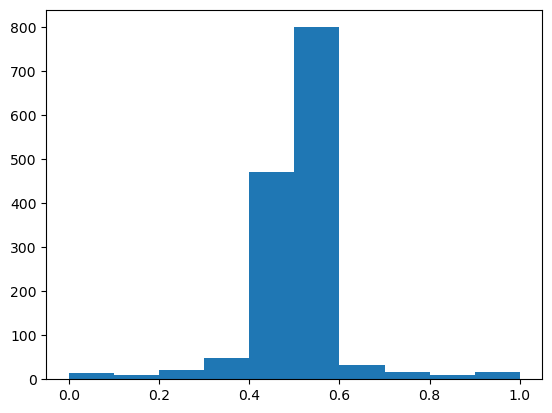

In [637]:
plt.hist(scipy.stats.norm.cdf(volume.test_df['zero_Z']))

In [658]:
vol_df

,index,lower,upper,value,start,offset,period,Observed,Rank,Observed Rank,error,rank_error,Absolute Error,Absolute Rank Error,Std,Observation Z-score,Start Observed,Higher
0,0,0.000000,0.000000,1885.90000,10,-10,0,1885.90000,162.0,138.0,0.0,24.0,0.0,24.0,0.000000,NaN,499.6,True
1,1,0.000000,0.000000,613.80000,10,-9,1,613.80000,158.0,67.0,0.0,91.0,0.0,91.0,0.000000,NaN,499.6,True
2,2,0.000000,0.000000,670.00000,10,-8,2,670.00000,159.0,74.0,0.0,85.0,0.0,85.0,0.000000,NaN,499.6,True
3,3,0.000000,0.000000,980.90000,10,-7,3,980.90000,160.0,99.0,0.0,61.0,0.0,61.0,0.000000,NaN,499.6,True
4,4,0.000000,0.000000,233.30000,10,-6,4,233.30000,156.0,18.0,0.0,138.0,0.0,138.0,0.000000,NaN,499.6,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26539,163,0.000000,0.000000,128.20000,167,-4,163,128.20000,12.0,12.0,0.0,0.0,0.0,0.0,0.000000,NaN,526.7,False
26540,164,0.000000,0.000000,50.50000,167,-3,164,50.50000,7.0,7.0,0.0,0.0,0.0,0.0,0.000000,NaN,526.7,False
26541,165,0.000000,0.000000,561.70000,167,-2,165,561.70000,61.0,61.0,0.0,0.0,0.0,0.0,0.000000,NaN,526.7,True
26542,166,0.000000,0.000000,526.70000,167,-1,166,526.70000,53.0,53.0,0.0,0.0,0.0,0.0,0.000000,NaN,526.7,False


In [662]:
updated_vol_df

,index,lower,upper,value,start,offset,period,Observed,Rank,Observed Rank,error,rank_error,Absolute Error,Absolute Rank Error,Std,Observation Z-score,Start Observed,Higher
0,0,0.000000,0.000000,1885.90000,10,-10,0,1885.90000,162.0,138.0,0.0,24.0,0.0,24.0,0.000000,NaN,499.6,True
1,1,0.000000,0.000000,613.80000,10,-9,1,613.80000,158.0,67.0,0.0,91.0,0.0,91.0,0.000000,NaN,499.6,True
2,2,0.000000,0.000000,670.00000,10,-8,2,670.00000,159.0,74.0,0.0,85.0,0.0,85.0,0.000000,NaN,499.6,True
3,3,0.000000,0.000000,980.90000,10,-7,3,980.90000,160.0,99.0,0.0,61.0,0.0,61.0,0.000000,NaN,499.6,True
4,4,0.000000,0.000000,233.30000,10,-6,4,233.30000,156.0,18.0,0.0,138.0,0.0,138.0,0.000000,NaN,499.6,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26539,163,0.000000,0.000000,128.20000,167,-4,163,128.20000,12.0,12.0,0.0,0.0,0.0,0.0,0.000000,NaN,526.7,False
26540,164,0.000000,0.000000,50.50000,167,-3,164,50.50000,7.0,7.0,0.0,0.0,0.0,0.0,0.000000,NaN,526.7,False
26541,165,0.000000,0.000000,561.70000,167,-2,165,561.70000,61.0,61.0,0.0,0.0,0.0,0.0,0.000000,NaN,526.7,True
26542,166,0.000000,0.000000,526.70000,167,-1,166,526.70000,53.0,53.0,0.0,0.0,0.0,0.0,0.000000,NaN,526.7,False


In [664]:
old_test_df

,index,lower,upper,value,start,offset,period,Observed,Rank,Observed Rank,...,Observation Z-score,Start Observed,Higher,Optimised Std,New Z-score,Start Z-score,Observed Higher,Prob Higher,Posterior Prediction,Posterior Higher
10,10,-75.687426,4075.687426,2000.000000,10,0,10,1500.000000,83.0,29.5,...,-0.472133,2000.0,False,2.044827e+03,-2.445194e-01,0.000000e+00,False,0.609212,2000.000000,False
11,11,-2207.247631,6207.247631,2000.000000,10,1,11,1900.000000,83.0,58.0,...,-0.046586,2000.0,False,-6.192272e+03,1.614916e-02,-0.000000e+00,False,0.609212,2000.000000,False
12,12,-4411.817367,8411.817367,2000.000000,10,2,12,1550.000000,83.0,33.0,...,-0.137559,2000.0,False,1.162028e+09,-3.872541e-07,0.000000e+00,False,0.609212,2000.000000,False
13,13,-6687.573032,10687.573032,2000.000000,10,3,13,1600.000000,83.0,36.5,...,-0.090244,2000.0,False,-4.956098e+05,8.070866e-04,-0.000000e+00,False,0.609212,2000.000000,False
14,14,-9032.793902,13032.793902,2000.000000,10,4,14,1600.000000,83.0,36.5,...,-0.071061,2000.0,False,-6.974175e+09,5.735446e-08,-0.000000e+00,False,0.609212,2000.000000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26206,166,4241.088122,5090.833684,4665.960903,165,1,166,4630.000000,137.0,137.0,...,-0.165893,4600.0,True,-6.192272e+03,5.807384e-03,1.065213e-02,True,0.610082,4654.080897,True
26207,167,4075.376597,5046.605095,4560.990846,165,2,167,4499.970344,133.0,118.0,...,-0.246286,4600.0,False,1.162028e+09,-5.251209e-08,3.356990e-08,False,0.609212,4982.137654,True
26374,166,4340.910318,5022.584046,4681.747182,166,0,166,4630.000000,138.0,137.0,...,-0.297575,4615.0,True,2.044827e+03,-2.530638e-02,-3.264197e-02,True,0.610082,4654.080897,True
26375,167,4149.303170,4995.698088,4572.500629,166,1,167,4499.970344,133.0,118.0,...,-0.335917,4615.0,False,-6.192272e+03,1.171303e-02,-6.863292e-03,False,0.608631,4548.908293,False


In [670]:
filt = test_df.period==100
(test_df.loc[filt].value/(test_df.loc[filt].Std**2)).sum()/(np.sum(filt)+1)

-3074857235.1887317

2124.588988498135
-119.38883696259764
-119.38883473228249


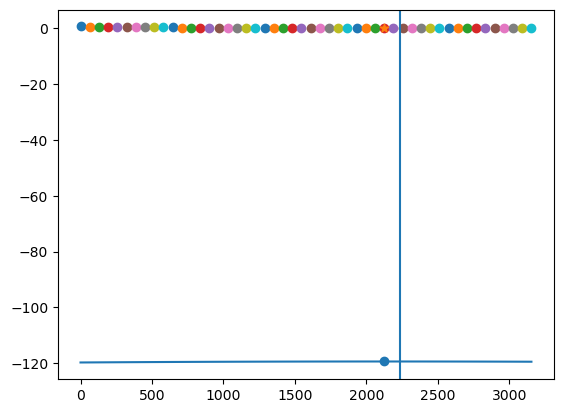

In [694]:
test_df = volume.test_df
pfilt = test_df.period==60
offset = 0
filt = pfilt&(test_df.offset>=offset)
std=test_df.loc[filt, 'Optimised Std']
x=test_df.loc[filt, 'value']
mus = np.linspace(0, x.max())
for mu in mus:
        plt.scatter(mu, np.sum(((x-mu)/(std))**2))

terms = [np.sum(((x-mu)/(std))**2) for mu in mus]
likes = [np.sum(log_gaussian(x, std=std, mu=mu)) for mu in mus]
plt.plot(mus, likes)
plt.scatter(mus[np.argmax(likes)], likes[np.argmax(likes)])

plt.scatter(mus[np.argmin(terms)], terms[np.argmin(terms)], marker='*')

print(mus[np.argmin(terms)])

peak_mu = sum(x/(std**2))/np.sum(std**-2)

print(max(likes))
print(np.sum(log_gaussian(x, std=std, mu=peak_mu)))

plt.axvline(test_df.loc[filt, 'Observed'].mean())

In [842]:
def update(row, df):
    filt = (df.period==row.period)&(df.offset>=row.offset)&(df.offset<=row.offset+10)
    x = df.loc[filt, 'value']
    std = df.loc[filt, 'Optimised Std']
    mu = df.loc[filt, 'Observed']
    return np.sum(x/(std**2))/np.sum(std**-2)

def update_value(df):
    for row_i in df.index:
        row = df.loc[row_i]
        df.loc[row_i, ["Posterior", "Posterior Std"]] = np.maximum(0, update(row, df))

In [702]:
for row_i in test_df.index:
    row = test_df.loc[row_i]
    test_df.loc[row_i, "Posterior"] = np.maximum(0, update(row, test_df))

In [712]:
volume.prediction_df

,index,lower,upper,value,start,offset,period,Observed,Rank,Observed Rank,...,Absolute Rank Error,Std,Observation Z-score,Start Observed,Higher,Optimised Std,New Z-score,Start Z-score,Observed Higher,Posterior
10,10,520.590199,4440.518168,2480.554183,10,0,10,1555.00000,163.0,128.0,...,35.0,999.981625,-0.925571,499.6,True,3265.188349,-0.283461,-0.606689,True,2480.554183
11,11,8021.372245,15861.228183,11941.300214,10,1,11,992.40000,168.0,102.0,...,66.0,1999.963250,-5.474551,499.6,True,-4061.326361,2.695893,2.817232,True,11941.300214
12,12,561.996323,12321.780231,6441.888277,10,2,12,1452.90000,166.0,122.0,...,44.0,2999.944874,-1.663027,499.6,True,51282.252746,-0.097285,-0.115874,True,6441.888277
13,13,2396.412811,18076.124688,10236.268750,10,3,13,948.80000,167.0,97.0,...,70.0,3999.926499,-2.321910,499.6,True,-22000.139511,0.422155,0.442573,True,10236.268750
14,14,-17114.874867,2484.764979,-7315.054944,10,4,14,832.20000,154.0,91.0,...,63.0,4999.908124,1.629481,499.6,False,-415204.568311,-0.019622,-0.018821,True,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26206,166,-1352.388719,2283.869121,465.740201,165,1,166,526.70000,48.0,53.0,...,5.0,927.616796,0.065717,50.5,True,-4061.326361,-0.015010,0.102243,True,463.775722
26207,167,-826.207274,2959.610426,1066.701576,165,2,167,1096.14636,105.0,107.0,...,2.0,965.769822,0.030488,50.5,True,51282.252746,0.000574,-0.019816,True,1087.525494
26374,166,-1094.919432,2163.339208,534.209888,166,0,166,526.70000,54.0,53.0,...,1.0,831.188429,-0.009035,561.7,False,3265.188349,-0.002300,0.008419,False,505.888305
26375,167,-687.471102,2899.058231,1105.793565,166,1,167,1096.14636,108.0,107.0,...,1.0,914.930952,-0.010544,561.7,True,-4061.326361,0.002375,0.133969,True,1105.083200


,index,lower,upper,value,start,offset,period,Observed,Rank,Observed Rank,error,rank_error,Absolute Error,Absolute Rank Error,Std,Observation Z-score,Start Observed,Higher
0,0,0.000000,0.000000,1885.90000,10,-10,0,NaN,162.0,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,499.6,True
1,1,0.000000,0.000000,613.80000,10,-9,1,NaN,158.0,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,499.6,True
2,2,0.000000,0.000000,670.00000,10,-8,2,NaN,159.0,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,499.6,True
3,3,0.000000,0.000000,980.90000,10,-7,3,NaN,160.0,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,499.6,True
4,4,0.000000,0.000000,233.30000,10,-6,4,NaN,156.0,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,499.6,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26539,163,0.000000,0.000000,128.20000,167,-4,163,NaN,12.0,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,526.7,False
26540,164,0.000000,0.000000,50.50000,167,-3,164,NaN,7.0,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,526.7,False
26541,165,0.000000,0.000000,561.70000,167,-2,165,NaN,61.0,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,526.7,True
26542,166,0.000000,0.000000,526.70000,167,-1,166,NaN,53.0,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,526.7,False


In [724]:
update_value(volume.prediction_df)

updated_vol_df = copy.deepcopy(volume.df)
updated_vol_df['Std'] = std_kernel(updated_vol_df['offset'], volume.w0)
updated_vol_df.loc[updated_vol_df.offset<0,'Std'] =0
updated_vol_df.loc[updated_vol_df.offset>=0,'Std'] = volume.prediction_df['Posterior']

newvolume = Prediction_Set(updated_vol_df)

In [736]:
def expectation_maximisation(obj):
    update_value(obj.prediction_df)

    updated_vol_df = copy.deepcopy(obj.df)
    updated_vol_df['Std'] = std_kernel(updated_vol_df['offset'], volume.w0)
    updated_vol_df.loc[updated_vol_df.offset<0,'Std'] =0
    updated_vol_df.loc[updated_vol_df.offset>=0,'Std'] = obj.prediction_df['Posterior']

    newvolume = Prediction_Set(updated_vol_df, w0=obj.w0)
    return newvolume

C:\Users\Meredith\AppData\Local\Temp\ipykernel_15424\1710673153.py:25: RuntimeWarning: Method Nelder-Mead cannot handle constraints.
  res = scipy.optimize.minimize(self.maximise_likelihood,


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 20250.01529959507
             x: [ 3.175e+03  6.237e+04 -8.817e+04  2.690e+04]
           nit: 324
          nfev: 577
 final_simplex: (array([[ 3.175e+03,  6.237e+04, -8.817e+04,  2.690e+04],
                       [ 3.175e+03,  6.237e+04, -8.817e+04,  2.690e+04],
                       ...,
                       [ 3.175e+03,  6.237e+04, -8.817e+04,  2.690e+04],
                       [ 3.175e+03,  6.237e+04, -8.817e+04,  2.690e+04]]), array([ 2.025e+04,  2.025e+04,  2.025e+04,  2.025e+04,
                        2.025e+04]))
       allvecs: [array([ 3.250e+03, -1.407e+05,  4.586e+04,  1.057e+04]), array([ 3.250e+03, -1.407e+05,  4.586e+04,  1.110e+04]), array([ 3.250e+03, -1.407e+05,  4.586e+04,  1.110e+04]), array([ 3.250e+03, -1.407e+05,  4.586e+04,  1.110e+04]), array([ 3.250e+03, -1.407e+05,  4.586e+04,  1.110e+04]), array([ 3.250e+03, -1.407e+05,  4.586e+04,  1.110e+04]

             message: Optimization terminated successfully.
             success: True
                 fun: 20192.42153923076
                   x: [-3.255e+03  2.261e+05 -1.876e+05  3.666e+04]
                 nit: 82
                nfev: 5715
          population: [[-2.583e+03  2.978e+05 -2.425e+05  4.574e+04]
                       [ 1.014e+04  1.826e+05 -1.717e+05  4.132e+04]
                       ...
                       [-1.349e+04  3.403e+05 -2.667e+05  4.472e+04]
                       [ 6.211e+03  2.811e+05 -2.288e+05  4.607e+04]]
 population_energies: [ 2.019e+04  2.072e+04 ...  2.057e+04  2.047e+04]
                 jac: [ 7.276e-04  0.000e+00  0.000e+00 -7.278e-04]

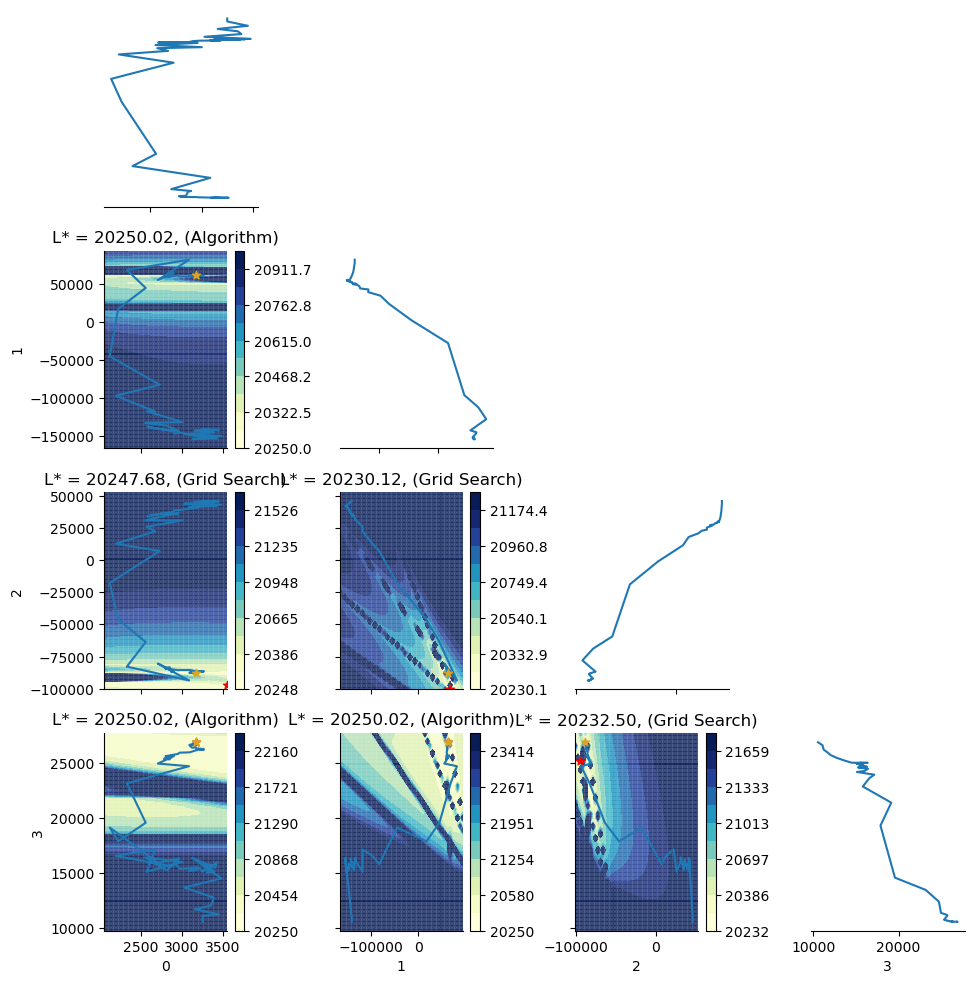

In [728]:
newvolume.optimise_likelihood()
newvolume.optimise_likelihood(method='Differential Evolution')

In [729]:
newvolume.apply_estimate()

In [740]:
vol3 = expectation_maximisation(newvolume)

In [741]:
vol3.optimise_likelihood(method='Differential Evolution')

             message: Optimization terminated successfully.
             success: True
                 fun: 20250.02253677201
                   x: [-3.184e+03 -6.228e+04  8.811e+04 -2.689e+04]
                 nit: 73
                nfev: 4690
          population: [[-1.750e+04 -2.596e+04  6.282e+04 -2.171e+04]
                       [-1.154e+04 -1.087e+06  6.331e+05 -8.710e+04]
                       ...
                       [-6.030e+04 -1.286e+04  5.450e+04 -1.949e+04]
                       [ 6.097e+04 -2.622e+05  1.642e+05 -2.985e+04]]
 population_energies: [ 2.025e+04  2.095e+04 ...  2.115e+04  2.096e+04]
                 jac: [-3.638e-04  0.000e+00 -3.639e-04 -3.638e-04]


             message: Optimization terminated successfully.
             success: True
                 fun: 20250.02253677201
                   x: [-3.184e+03 -6.228e+04  8.811e+04 -2.689e+04]
                 nit: 73
                nfev: 4690
          population: [[-1.750e+04 -2.596e+04  6.282e+04 -2.171e+04]
                       [-1.154e+04 -1.087e+06  6.331e+05 -8.710e+04]
                       ...
                       [-6.030e+04 -1.286e+04  5.450e+04 -1.949e+04]
                       [ 6.097e+04 -2.622e+05  1.642e+05 -2.985e+04]]
 population_energies: [ 2.025e+04  2.095e+04 ...  2.115e+04  2.096e+04]
                 jac: [-3.638e-04  0.000e+00 -3.639e-04 -3.638e-04]

C:\Users\Meredith\AppData\Local\Temp\ipykernel_15424\2731367708.py:27: RuntimeWarning: Method Nelder-Mead cannot handle constraints.
  res = scipy.optimize.minimize(self.maximise_likelihood,


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 20250.01529959507
             x: [-3.175e+03 -6.237e+04  8.817e+04 -2.690e+04]
           nit: 161
          nfev: 310
 final_simplex: (array([[-3.175e+03, -6.237e+04,  8.817e+04, -2.690e+04],
                       [-3.175e+03, -6.237e+04,  8.817e+04, -2.690e+04],
                       ...,
                       [-3.175e+03, -6.237e+04,  8.817e+04, -2.690e+04],
                       [-3.175e+03, -6.237e+04,  8.817e+04, -2.690e+04]]), array([ 2.025e+04,  2.025e+04,  2.025e+04,  2.025e+04,
                        2.025e+04]))
       allvecs: [array([-3.184e+03, -6.228e+04,  8.811e+04, -2.689e+04]), array([-3.184e+03, -6.228e+04,  8.811e+04, -2.689e+04]), array([-3.184e+03, -6.228e+04,  8.811e+04, -2.689e+04]), array([-3.184e+03, -6.228e+04,  8.811e+04, -2.689e+04]), array([-3.184e+03, -6.228e+04,  8.811e+04, -2.689e+04]), array([-3.184e+03, -6.228e+04,  8.811e+04, -2.689e+04]

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 20250.01529959507
             x: [-3.175e+03 -6.237e+04  8.817e+04 -2.690e+04]
           nit: 161
          nfev: 310
 final_simplex: (array([[-3.175e+03, -6.237e+04,  8.817e+04, -2.690e+04],
                       [-3.175e+03, -6.237e+04,  8.817e+04, -2.690e+04],
                       ...,
                       [-3.175e+03, -6.237e+04,  8.817e+04, -2.690e+04],
                       [-3.175e+03, -6.237e+04,  8.817e+04, -2.690e+04]]), array([ 2.025e+04,  2.025e+04,  2.025e+04,  2.025e+04,
                        2.025e+04]))
       allvecs: [array([-3.184e+03, -6.228e+04,  8.811e+04, -2.689e+04]), array([-3.184e+03, -6.228e+04,  8.811e+04, -2.689e+04]), array([-3.184e+03, -6.228e+04,  8.811e+04, -2.689e+04]), array([-3.184e+03, -6.228e+04,  8.811e+04, -2.689e+04]), array([-3.184e+03, -6.228e+04,  8.811e+04, -2.689e+04]), array([-3.184e+03, -6.228e+04,  8.811e+04, -2.689e+04]

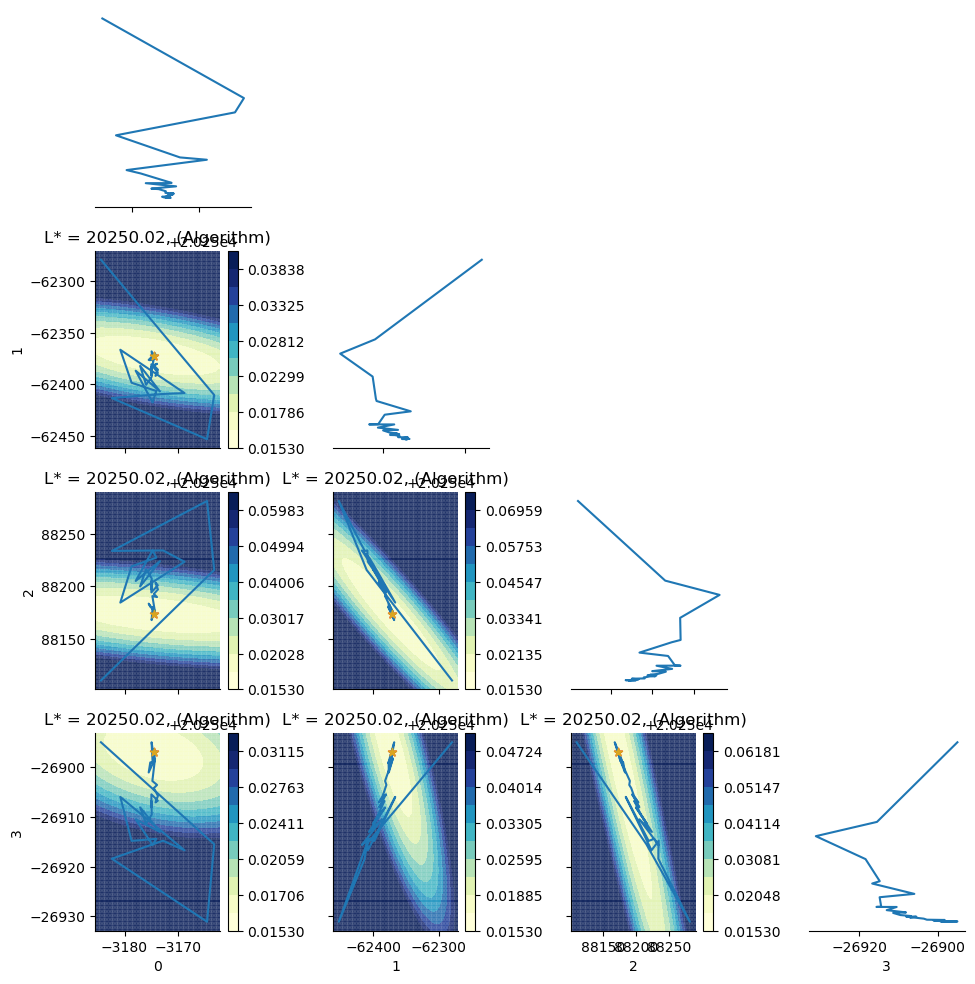

In [742]:
vol3.optimise_likelihood()

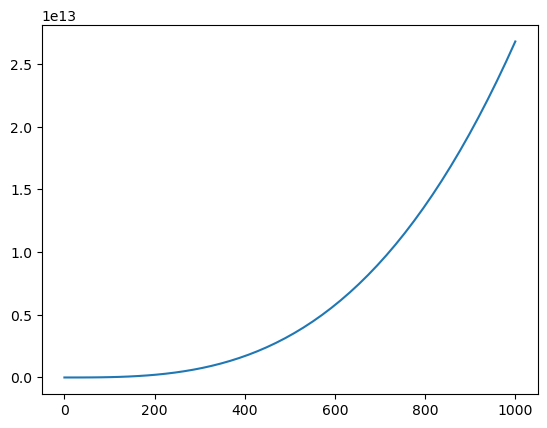

In [763]:
volume.prediction_df

,index,lower,upper,value,start,offset,period,Observed,Rank,Observed Rank,error,rank_error,Absolute Error,Absolute Rank Error,Std,Observation Z-score,Start Observed,Higher
10,10,520.590199,4440.518168,2480.554183,10,0,10,1555.00000,163.0,128.0,925.554183,35.0,925.554183,35.0,999.981625,-0.925571,499.6,True
11,11,8021.372245,15861.228183,11941.300214,10,1,11,992.40000,168.0,102.0,10948.900214,66.0,10948.900214,66.0,1999.963250,-5.474551,499.6,True
12,12,561.996323,12321.780231,6441.888277,10,2,12,1452.90000,166.0,122.0,4988.988277,44.0,4988.988277,44.0,2999.944874,-1.663027,499.6,True
13,13,2396.412811,18076.124688,10236.268750,10,3,13,948.80000,167.0,97.0,9287.468750,70.0,9287.468750,70.0,3999.926499,-2.321910,499.6,True
14,14,-17114.874867,2484.764979,-7315.054944,10,4,14,832.20000,154.0,91.0,-8147.254944,63.0,8147.254944,63.0,4999.908124,1.629481,499.6,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26206,166,-1352.388719,2283.869121,465.740201,165,1,166,526.70000,48.0,53.0,-60.959799,-5.0,60.959799,5.0,927.616796,0.065717,50.5,True
26207,167,-826.207274,2959.610426,1066.701576,165,2,167,1096.14636,105.0,107.0,-29.444784,-2.0,29.444784,2.0,965.769822,0.030488,50.5,True
26374,166,-1094.919432,2163.339208,534.209888,166,0,166,526.70000,54.0,53.0,7.509888,1.0,7.509888,1.0,831.188429,-0.009035,561.7,False
26375,167,-687.471102,2899.058231,1105.793565,166,1,167,1096.14636,108.0,107.0,9.647205,1.0,9.647205,1.0,914.930952,-0.010544,561.7,True


In [765]:
update_value(volume.prediction_df)

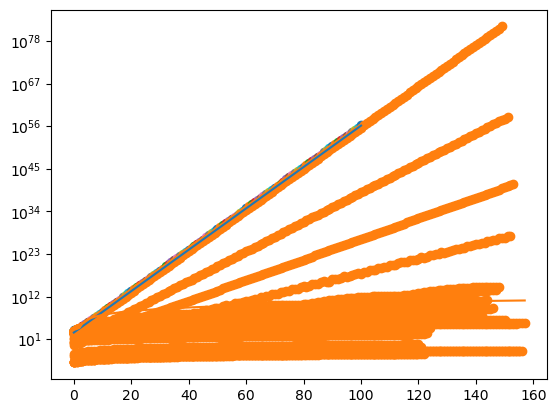

In [794]:
test_df = volume.prediction_df
new_stds = []
offsets=test_df[test_df.offset<=100].offset.unique()

for offset in offsets:
    filt = test_df.offset==offset
    x = test_df.loc[filt, 'value']
    mu = test_df.loc[filt, 'Observed']
    plt.scatter(offset, np.sqrt(np.sum((x-mu)**2)/len(x)))
    new_stds.append(np.sqrt(np.sum((x-mu)**2)/len(x)))

    
res = scipy.stats.linregress(offsets, np.log(new_stds))
x = test_df.offset.unique()

plt.plot(np.exp(res.intercept + res.slope*offsets))
plt.plot(x, std_kernel(x, vol3.w0))
plt.yscale('log')

plt.scatter(test_df.offset, test_df.Std)

In [793]:
test_df['New Stds'] - test_df['Std']

10        2229.873400
11        1942.216971
12        4883.380249
13       17270.843300
14       63528.749669
             ...     
26206     3014.563425
26207     6917.555302
26374     2398.666596
26375     3027.249268
26543     2402.891758
Length: 11275, dtype: float64

In [779]:
np.sqrt(np.sum((x-mu)**2)/len(x))

3229.855024933046

In [787]:
test_df['New Stds'] = test_df.offset.map(pd.Series(index=offsets, data=new_stds))

In [792]:
np.sum(log_gaussian(test_df['offset'], std=test_df['Optimised Std'], mu=test_df['Observed']))

-226722.45327976363

In [791]:
np.sum(log_gaussian(test_df['offset'], std=test_df['New Stds'], mu=test_df['Observed']))

-574547.3891478485

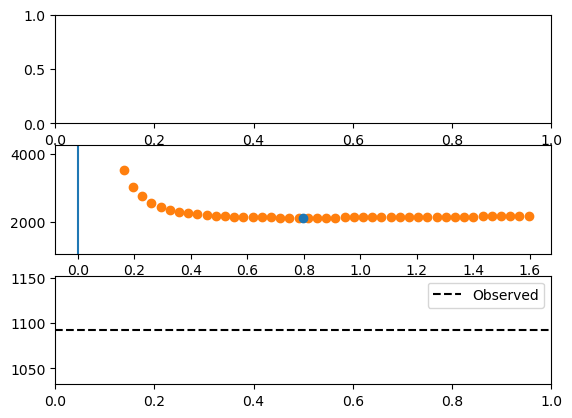

In [836]:
fig, ax = plt.subplots(3)
offset = 6
filt = (test_df.offset==offset)
#std=test_df.loc[filt, 'Optimised Std']
x=test_df.loc[filt, 'value']
#mus = np.linspace(0, x.max())
mu = test_df.loc[filt, 'Observed']
#likes = [np.sum(log_gaussian(x, std=std, mu=mu)) for mu in mus]


pred_std = np.sqrt(np.sum((x-mu)**2)/len(x))
prob_pred = -np.sum(log_gaussian(x, std=np.repeat([pred_std], len(x)), mu=mu))

ax[1].scatter(pred_std, prob_pred, zorder=10)
stds = np.linspace(0.1, pred_std*2)
for s in stds:
    #ax[0].scatter(mu, np.sum(((x-mu)/(std))**2))
    std = np.repeat([s], len(x))
    ax[1].scatter(s, -np.sum(log_gaussian(x, std=std, mu=mu)), c='C1')
    this_prob = -np.sum(log_gaussian(x, std=std, mu=mu))
    if this_prob <= prob_pred:
        print('lower!')

    #print()
#ax[0].scatter(x, np.repeat(offset, len(x)), c=cmap.get_cmap()(norm(test_df.loc[filt, 'offset'])))

#ax[1].plot(mus, likes, color=cmap.get_cmap()(norm(offset)))
#ax[1].scatter(mus[np.argmax(likes)], likes[np.argmax(likes)], color=cmap.get_cmap()(norm(offset)))
#ax[1].scatter(x.mean(), 1, marker='x', color=cmap.get_cmap()(norm(offset)))
ax[1].axvline(test_df.loc[filt, 'Observed'].mean())

#reg_pred = regress_error(test_df.loc[filt])
#ax[1].scatter(reg_pred, 0, marker='s', color=cmap.get_cmap()(norm(offset)))
#regs_found.append(reg_pred)
mus_found.append(mus[np.argmax(likes)])
means_found.append(x.mean())

#ax[1].set_yscale('log')
ax[1].set_ylim(0.5*-np.sum(log_gaussian(x, std=np.repeat([pred_std], len(x)), mu=mu)), 2*-np.sum(log_gaussian(x, std=np.repeat([pred_std], len(x)), mu=mu)))

ax[2].axhline(test_df.loc[filt, 'Observed'].mean(), label='Observed', ls='--', c='k')
ax[2].legend()

In [992]:
def set_std(row, df):
    if row.offset < 0:
        return 0
    filt = (df.offset == row.offset)&(df.period <= row.start) # Compare with already known points
    if np.sum(filt)==0:
        return row.Std
    x = df.loc[filt, 'value']
    mu = df.loc[filt, 'Observed']
    std = np.sqrt(np.sum((x-mu)**2)/len(x))
    return std

def set_val(row, df):
    if row.offset <0:
        return row.Observed

    filt = (df.period==row.period)&(df.offset>=row.offset)&(df.offset<=row.offset+10)
    if np.sum(filt)==0:
        return row.value
    x = df.loc[filt, 'value']
    std = df.loc[filt, 'Std']
    
    return np.sum(x/(std**2))/np.sum(std**-2)

In [1073]:
def mse(df, col1='value', col2='Observed'):
    preds = df.offset >=0
    return np.sqrt(((df.loc[preds, col1] - df.loc[preds, col2])**2).mean())


    

In [906]:
mse(df)

7.665225332058813e+115

In [1284]:
df = copy.deepcopy(price.df)
df_volume = copy.deepcopy(volume.df)

In [1285]:
df[df.offset <0]

,index,lower,upper,value,start,offset,period,Observed,Rank,Observed Rank,error,rank_error,Absolute Error,Absolute Rank Error,Std,Observation Z-score,Start Observed,Higher
0,0,0.0,0.0,2200.0,10,-10,0,2200.0,167.5,68.5,0.0,99.0,0.0,99.0,0.0,NaN,2000.0,True
1,1,0.0,0.0,2050.0,10,-9,1,2050.0,164.0,65.0,0.0,99.0,0.0,99.0,0.0,NaN,2000.0,True
2,2,0.0,0.0,2000.0,10,-8,2,2000.0,83.0,62.5,0.0,20.5,0.0,20.5,0.0,NaN,2000.0,False
3,3,0.0,0.0,2100.0,10,-7,3,2100.0,165.0,66.0,0.0,99.0,0.0,99.0,0.0,NaN,2000.0,True
4,4,0.0,0.0,1650.0,10,-6,4,1650.0,1.0,44.0,0.0,-43.0,0.0,43.0,0.0,NaN,2000.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26538,162,0.0,0.0,5000.0,167,-5,162,5000.0,152.5,152.5,0.0,0.0,0.0,0.0,0.0,NaN,4630.0,True
26539,163,0.0,0.0,4700.0,167,-4,163,4700.0,139.0,139.0,0.0,0.0,0.0,0.0,0.0,NaN,4630.0,True
26540,164,0.0,0.0,4600.0,167,-3,164,4600.0,134.5,134.5,0.0,0.0,0.0,0.0,0.0,NaN,4630.0,False
26541,165,0.0,0.0,4615.0,167,-2,165,4615.0,136.0,136.0,0.0,0.0,0.0,0.0,0.0,NaN,4630.0,False


In [1]:
def expect_max(df, its=1, mses=[], dataset_name=''):
    
    mses.append(mse(df))
    dfs=[]
    for k in range(its):

        for row_i in df.index[df.offset >=0]:
            df.loc[row_i, 'Std'] = set_std(df.loc[row_i], df)
            df.loc[row_i, 'value'] = np.maximum(set_val(df.loc[row_i], df), 0)
            dfs.append(copy.deepcopy(df))
        mses.append(mse(df))
        if mses[-1] > mses[-2]:
            break # Worsening performance, don't waste time continuing

    fig, ax = plt.subplots(2)
    ax[0].plot(mses)
    ax[1].bar(range(len(mses)), scipy.stats.rankdata(mses))
    fig.suptitle(f'Progression of Performance\n{dataset_name}')
    ax[1].title.set_text("Ranking of MSE")
    ax[0].title.set_text("MSE")

    fig.tight_layout()
    return mses, dfs[np.argmin(mses)]

[1.9380136683017044e+44,
 1.9380136683017044e+44,
 2.379913262394134e+43,
 3.496594283588878e+42,
 5.100722003136607e+41,
 6.863752531569803e+40]

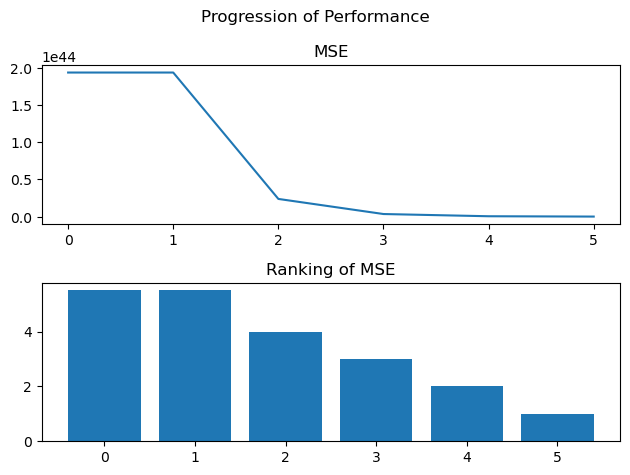

In [1290]:
# Run Expectation Maximisation for predicted volume
mses, df_volume = expect_max(df_volume, its=4)

We see that the performance improves across iteratrions for volumes but not for price

In [1292]:
mses, df = expect_max(df, its=4)

C:\Users\Meredith\AppData\Local\Temp\ipykernel_15424\709243761.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Higher'] = df['value'] > df['Start Observed']
C:\Users\Meredith\AppData\Local\Temp\ipykernel_15424\709243761.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Observed Higher'] = df['Observed'] > df['Start Observed']


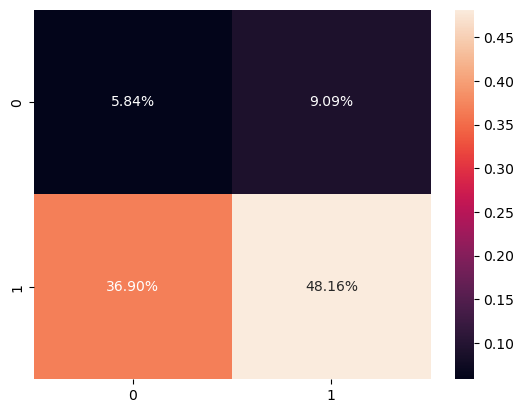

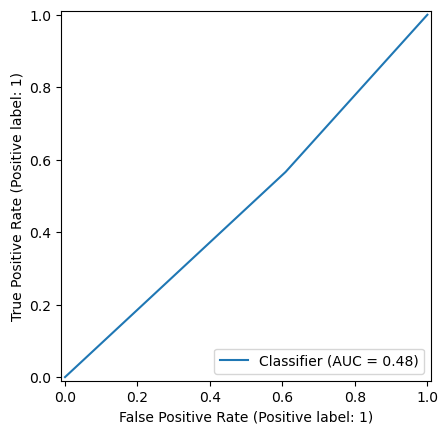

In [1197]:
df['Higher'] = df['value'] > df['Start Observed']
df['Observed Higher'] = df['Observed'] > df['Start Observed']

make_confusion_matrix(df.loc[df.offset>=0, 'Observed Higher'], df.loc[df.offset>=0,'Higher'])

In [1018]:
df.loc[df.start==df.start.max()]

,index,lower,upper,value,start,offset,period,Observed,Rank,Observed Rank,error,rank_error,Absolute Error,Absolute Rank Error,Std,Observation Z-score,Start Observed,Higher,Observed Higher
26543,167,4159.767061,4840.173626,4096.270919,167,0,167,4499.970344,118.0,118.0,0.0,0.0,0.0,0.0,1.571513e+07,0.0,4630.0,False,False


(0.0, 5300.0)

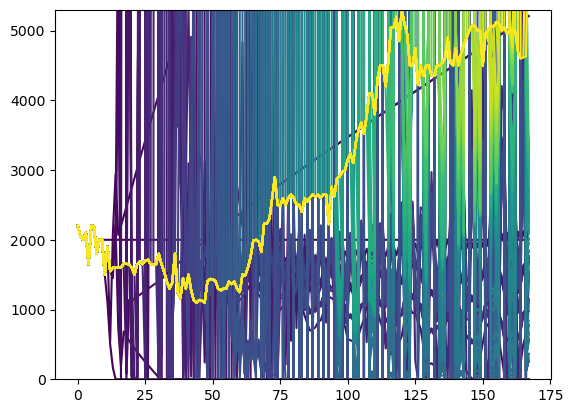

In [1039]:
# Set up for consistent colour mapping
norm = mpl.colors.Normalize(vmin=min(df.start.unique()), vmax=max(df.start.unique()))
map = cm.ScalarMappable(norm=norm, cmap='viridis')

# Plotting the data for different starts

for start in df.start.unique():
    plt.plot(df.loc[df.start==start, 'period'], df.loc[df.start==start, 'value'], c=map.get_cmap()(norm(start)))

plt.ylim(0, df.loc[df.offset<0, 'value'].max())

In [1050]:
df

,index,lower,upper,value,start,offset,period,Observed,Rank,Observed Rank,error,rank_error,Absolute Error,Absolute Rank Error,Std,Observation Z-score,Start Observed,Higher,Observed Higher,Start Z
0,0,0.000000,0.000000,2200.000000,10,-10,0,2200.000000,167.5,68.5,0.0,99.0,0.0,99.0,0.000000e+00,NaN,2000.0,True,True,-inf
1,1,0.000000,0.000000,2050.000000,10,-9,1,2050.000000,164.0,65.0,0.0,99.0,0.0,99.0,0.000000e+00,NaN,2000.0,True,True,-inf
2,2,0.000000,0.000000,2000.000000,10,-8,2,2000.000000,83.0,62.5,0.0,20.5,0.0,20.5,0.000000e+00,NaN,2000.0,False,False,NaN
3,3,0.000000,0.000000,2100.000000,10,-7,3,2100.000000,165.0,66.0,0.0,99.0,0.0,99.0,0.000000e+00,NaN,2000.0,True,True,-inf
4,4,0.000000,0.000000,1650.000000,10,-6,4,1650.000000,1.0,44.0,0.0,-43.0,0.0,43.0,0.000000e+00,NaN,2000.0,False,False,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26539,163,0.000000,0.000000,4700.000000,167,-4,163,4700.000000,139.0,139.0,0.0,0.0,0.0,0.0,0.000000e+00,NaN,4630.0,True,True,-inf
26540,164,0.000000,0.000000,4600.000000,167,-3,164,4600.000000,134.5,134.5,0.0,0.0,0.0,0.0,0.000000e+00,NaN,4630.0,False,False,inf
26541,165,0.000000,0.000000,4615.000000,167,-2,165,4615.000000,136.0,136.0,0.0,0.0,0.0,0.0,0.000000e+00,NaN,4630.0,False,False,inf
26542,166,0.000000,0.000000,4630.000000,167,-1,166,4630.000000,137.0,137.0,0.0,0.0,0.0,0.0,0.000000e+00,NaN,4630.0,False,False,NaN


In [1042]:
df['Start Z'] = (df['Start Observed'] - df['value'])/df['Std']

In [1074]:
scipy.stats.norm.cdf(df.loc[df.offset>=0, 'Start Z'])
df['Prob Higher'] = 1-scipy.stats.norm.cdf(df['Start Z'])
print(mse(df, col1='Prob Higher', col2='Observed Higher'))

(df['Higher'] - df['Prob Higher'])[df.offset>=0].describe()

0.49342744129665445


count    11080.000000
mean        -0.027625
std          0.411034
min         -0.500000
25%         -0.497538
50%          0.000000
75%          0.495381
max          0.500000
dtype: float64

In [1078]:
df['Numeric Observed Higher'] = df['Observed Higher'].astype(int)
print(mse(df, col1='Higher', col2='Numeric Observed Higher'))

0.6781707836631905


In [1080]:
df['Z Higher'] = df['Start Z'] < 0
print(mse(df, col1='Z Higher', col2='Numeric Observed Higher'))

0.7330604322462465


In [1061]:
df['Prob Higher']

0        1.0
1        1.0
2        NaN
3        1.0
4        0.0
        ... 
26539    1.0
26540    0.0
26541    0.0
26542    NaN
26543    0.5
Name: Prob Higher, Length: 26544, dtype: float64

In [1063]:
df['Higher']-1

0        0
1        0
2       -1
3        0
4       -1
        ..
26539    0
26540   -1
26541   -1
26542   -1
26543    0
Name: Higher, Length: 26544, dtype: int32

0        0.0
1        0.0
2        NaN
3        0.0
4        0.0
        ... 
26539    0.0
26540    0.0
26541    0.0
26542    NaN
26543    0.5
Length: 26544, dtype: float64

<AxesSubplot: xlabel='Start Z', ylabel='Density'>

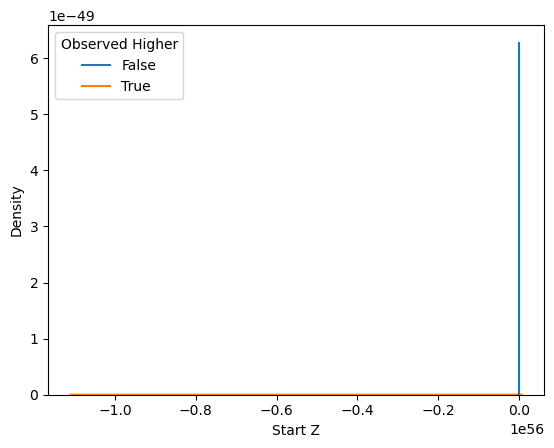

In [1044]:
sns.kdeplot(df, x='Start Z', hue='Observed Higher')
#plt.xlim(-3, 3)

In [1215]:
actually_higher = df.loc[df['Observed Higher']&(df.offset>=0), 'Start Z']
actually_lower = df.loc[(~df['Observed Higher'])&(df.offset>=0), 'Start Z']

In [ ]:
gaussian(mu=actually_lower.mean, std=actually_lower.st)

In [1226]:
ests =  (actually_lower.count()/actually_higher.count()) *scipy.stats.norm(loc=actually_lower.median(), scale=actually_lower.std()).pdf(df.loc[(df.offset>=0), 'Start Z'])/scipy.stats.norm(loc=actually_higher.median(), scale=actually_higher.std()).pdf(df.loc[(df.offset>=0), 'Start Z'])

C:\Users\Meredith\AppData\Local\Temp\ipykernel_15424\1077722245.py:1: RuntimeWarning: invalid value encountered in divide
  ests =  (actually_lower.count()/actually_higher.count()) *scipy.stats.norm(loc=actually_lower.median(), scale=actually_lower.std()).pdf(df.loc[(df.offset>=0), 'Start Z'])/scipy.stats.norm(loc=actually_higher.median(), scale=actually_higher.std()).pdf(df.loc[(df.offset>=0), 'Start Z'])


In [1234]:
def prob_df(df, x):
    filt = (df < df.quantile(0.75))&(df > df.quantile(0.25))
    return df.count()*scipy.stats.norm(loc=df.loc[filt].mean(), scale=df.loc[filt].std()).pdf(x)

x = df.loc[(df.offset>=0), 'Start Z']
prob_lower = prob_df(actually_lower, x)
prob_higher= prob_df(actually_higher, x)

ests = prob_higher/prob_lower

C:\Users\Meredith\AppData\Local\Temp\ipykernel_15424\3414606441.py:9: RuntimeWarning: divide by zero encountered in divide
  ests = prob_higher/prob_lower
C:\Users\Meredith\AppData\Local\Temp\ipykernel_15424\3414606441.py:9: RuntimeWarning: overflow encountered in divide
  ests = prob_higher/prob_lower
C:\Users\Meredith\AppData\Local\Temp\ipykernel_15424\3414606441.py:9: RuntimeWarning: invalid value encountered in divide
  ests = prob_higher/prob_lower


In [1251]:
ests[np.isinf(ests)] = np.nan

In [1254]:
np.unique(ests)

array([2.72958982e-002, 2.72962636e-002, 2.72965127e-002, ...,
       6.62728417e+307, 1.68285474e+308,             nan])

<AxesSubplot: >

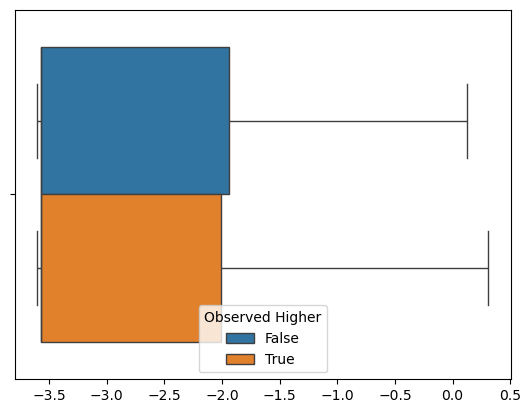

In [1260]:
sns.boxplot(x=np.log(ests), hue=df.loc[(df.offset>=0), 'Observed Higher'],showfliers=False)

(-0.03483829031521869, 0.03441800066759999)

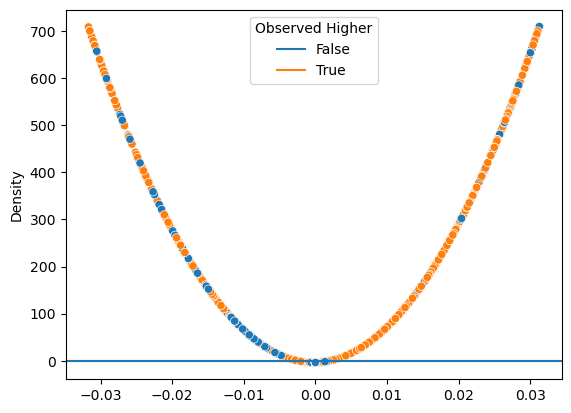

In [1263]:
sns.scatterplot(x=x.values, y=np.log(ests), hue=df.loc[(df.offset>=0), 'Observed Higher'])
xl = plt.gca().get_xlim()
sns.kdeplot(x=x.values, hue=df.loc[(df.offset>=0), 'Observed Higher'])
plt.xlim(xl)

In [1270]:
df.loc[(df.offset>=0), 'Distribution Informed Ratio'] =  ests
df.loc[:, 'Distribution Informed Higher'] = df['Observed Higher']
df.loc[(df.offset>=0), 'Distribution Informed Higher'] = ests < 1

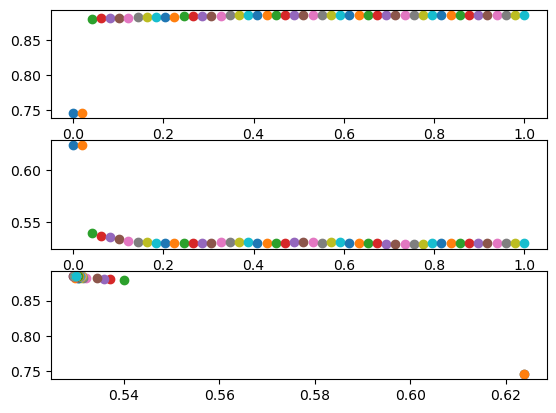

In [1278]:
import sklearn
fig, ax = plt.subplots(3)
for thresh in np.linspace(0, 1):
    df.loc[(df.offset>=0), 'Distribution Informed Higher'] = ests > thresh
    x=df.loc[(df.offset>=0), 'Distribution Informed Higher'].astype(int)
    y= df.loc[(df.offset>=0), 'Observed Higher'].astype(int)
    ax[0].scatter(thresh, mse(df, col1='Observed Higher', col2='Distribution Informed Higher'))

    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y, x, pos_label=0)
    ax[1].scatter(thresh, sklearn.metrics.auc(fpr, tpr))

    ax[2].scatter(sklearn.metrics.auc(fpr, tpr), mse(df, col1='Observed Higher', col2='Distribution Informed Higher'))
   # ax[2].set_xscale('log')
   # ax[2].set_yscale('log')

In [1162]:
(df.loc[(df.offset>=0), 'Distribution Informed Higher']).unique()

array([True, False], dtype=object)

In [1163]:
np.mean(df.loc[(df.offset>=0), 'Observed Higher'] == df.loc[(df.offset>=0), 'Distribution Informed Higher'])

0.7209617068704721

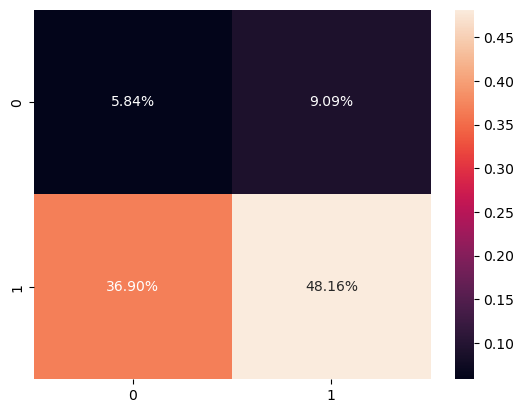

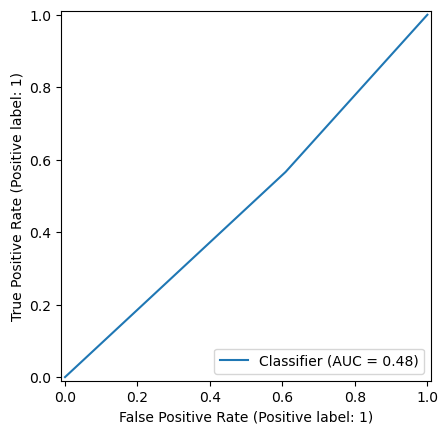

In [1237]:
make_confusion_matrix(df.loc[df.offset>=0, 'Observed Higher'], df.loc[df.offset>=0,'Higher'])

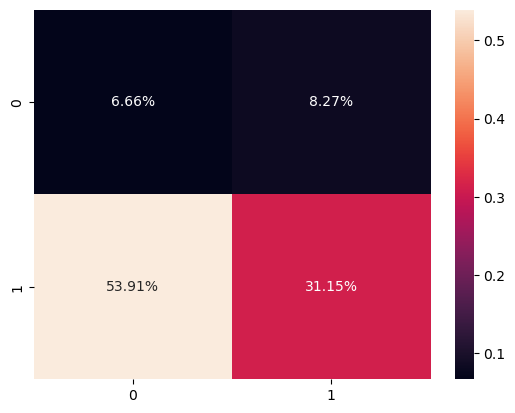

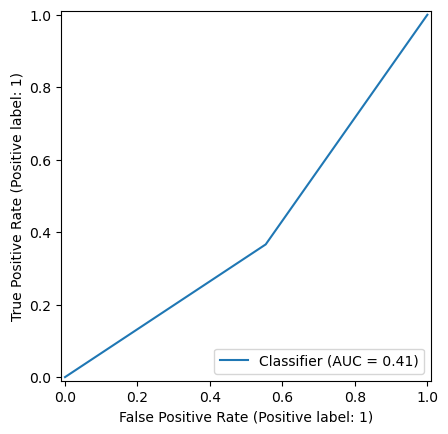

In [1271]:

make_confusion_matrix(df.loc[(df.offset>=0), 'Observed Higher'].astype(bool), df.loc[(df.offset>=0), 'Distribution Informed Higher'].astype(bool))

KeyboardInterrupt: 

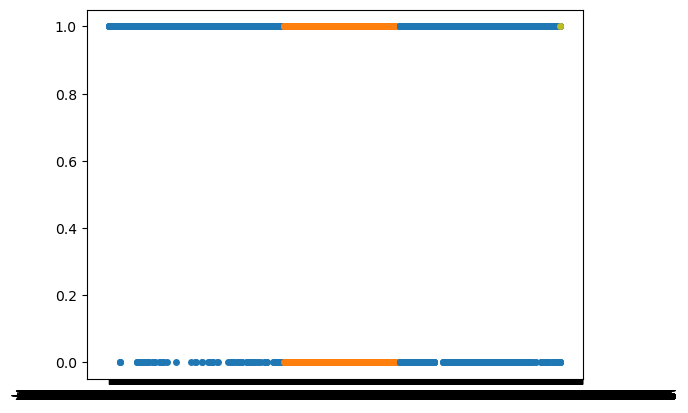

In [1240]:
sns.swarmplot(df.loc[(df.offset>=0)], x='Start Z', hue='Distribution Informed Higher', y='Observed Higher')

In [1221]:
actually_higher.describe()

count    9.206000e+03
mean    -3.493632e+52
std      1.431150e+54
min     -1.102897e+56
25%     -1.226098e+00
50%     -1.415212e-52
75%      1.815638e-05
max      5.258651e+14
Name: Start Z, dtype: float64

In [1222]:
actually_lower.describe()

count    1.874000e+03
mean    -8.465674e+45
std      2.135550e+47
min     -6.335538e+48
25%     -5.627500e-03
50%     -1.821455e-51
75%      2.711589e-08
max      6.182420e+01
Name: Start Z, dtype: float64

<AxesSubplot: ylabel='Start Z'>

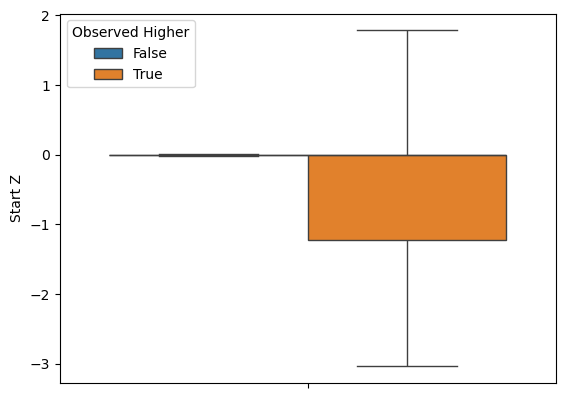

In [1214]:
sns.boxplot(df[df.offset>=0], y='Start Z', hue='Observed Higher', showfliers=False)

<AxesSubplot: xlabel='Higher', ylabel='Start Z'>

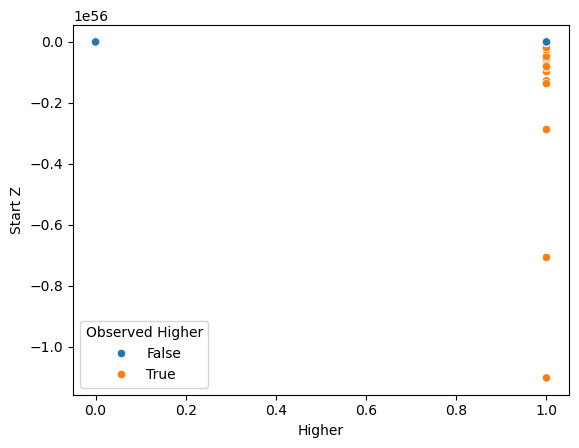

In [1084]:
sns.scatterplot(df, x='Higher', y='Start Z', hue='Observed Higher')

c:\Users\Meredith\anaconda3\envs\ELEN90088\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


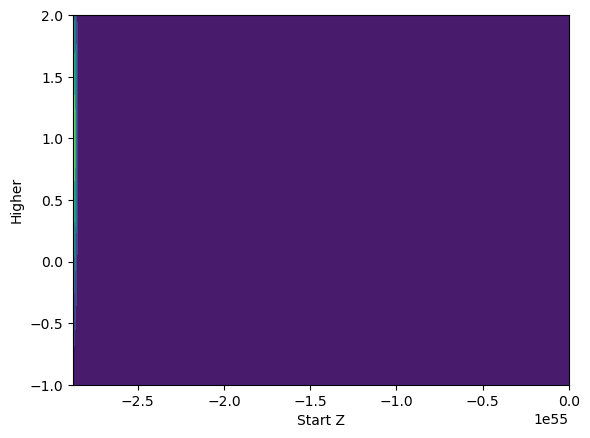

In [1097]:
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split

n = 100
train = np.random.choice(df.index[df.offset>=0], n, replace=False)
train = df[(df.period < n)&(df.offset>=0)].dropna().index
test = ~np.in1d(df.dropna().index, train)
X = df.dropna()[['Start Z', 'Higher']]
Y = df.dropna()['Observed Higher']
model = SVC(kernel='rbf', gamma=0.7, C=1, probability=True)
model.fit(X.loc[train].values, Y.loc[train].values)

fig, ax = plt.subplots()
DecisionBoundaryDisplay.from_estimator(model, X, ax=ax)

#for filt, marker in zip([train, test], ['.', 's']):
 #   ax.scatter(X.iloc[:, 0][filt], X.iloc[:, 1][filt], c=Y[filt], marker=marker)

#ax.set_xlim(-3, 3)

In [1095]:
X.loc[train].values

array([[-4.547473508864641e-16, True],
       [0.0, False],
       [0.0, False],
       ...,
       [-0.030807822408988425, True],
       [-0.010046395392455934, True],
       [0.010726750551218805, False]], dtype=object)